In [1]:

import os
from os.path import join
import yaml
import pickle
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm
import torch

import ili
from ili.dataloaders import StaticNumpyLoader, SBISimulator
from ili.validation.runner import ValidationRunner 
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


from CASBI.generator.fff.fff_model import FreeFormFlow
from CASBI.utils.create_dataframe import rescale


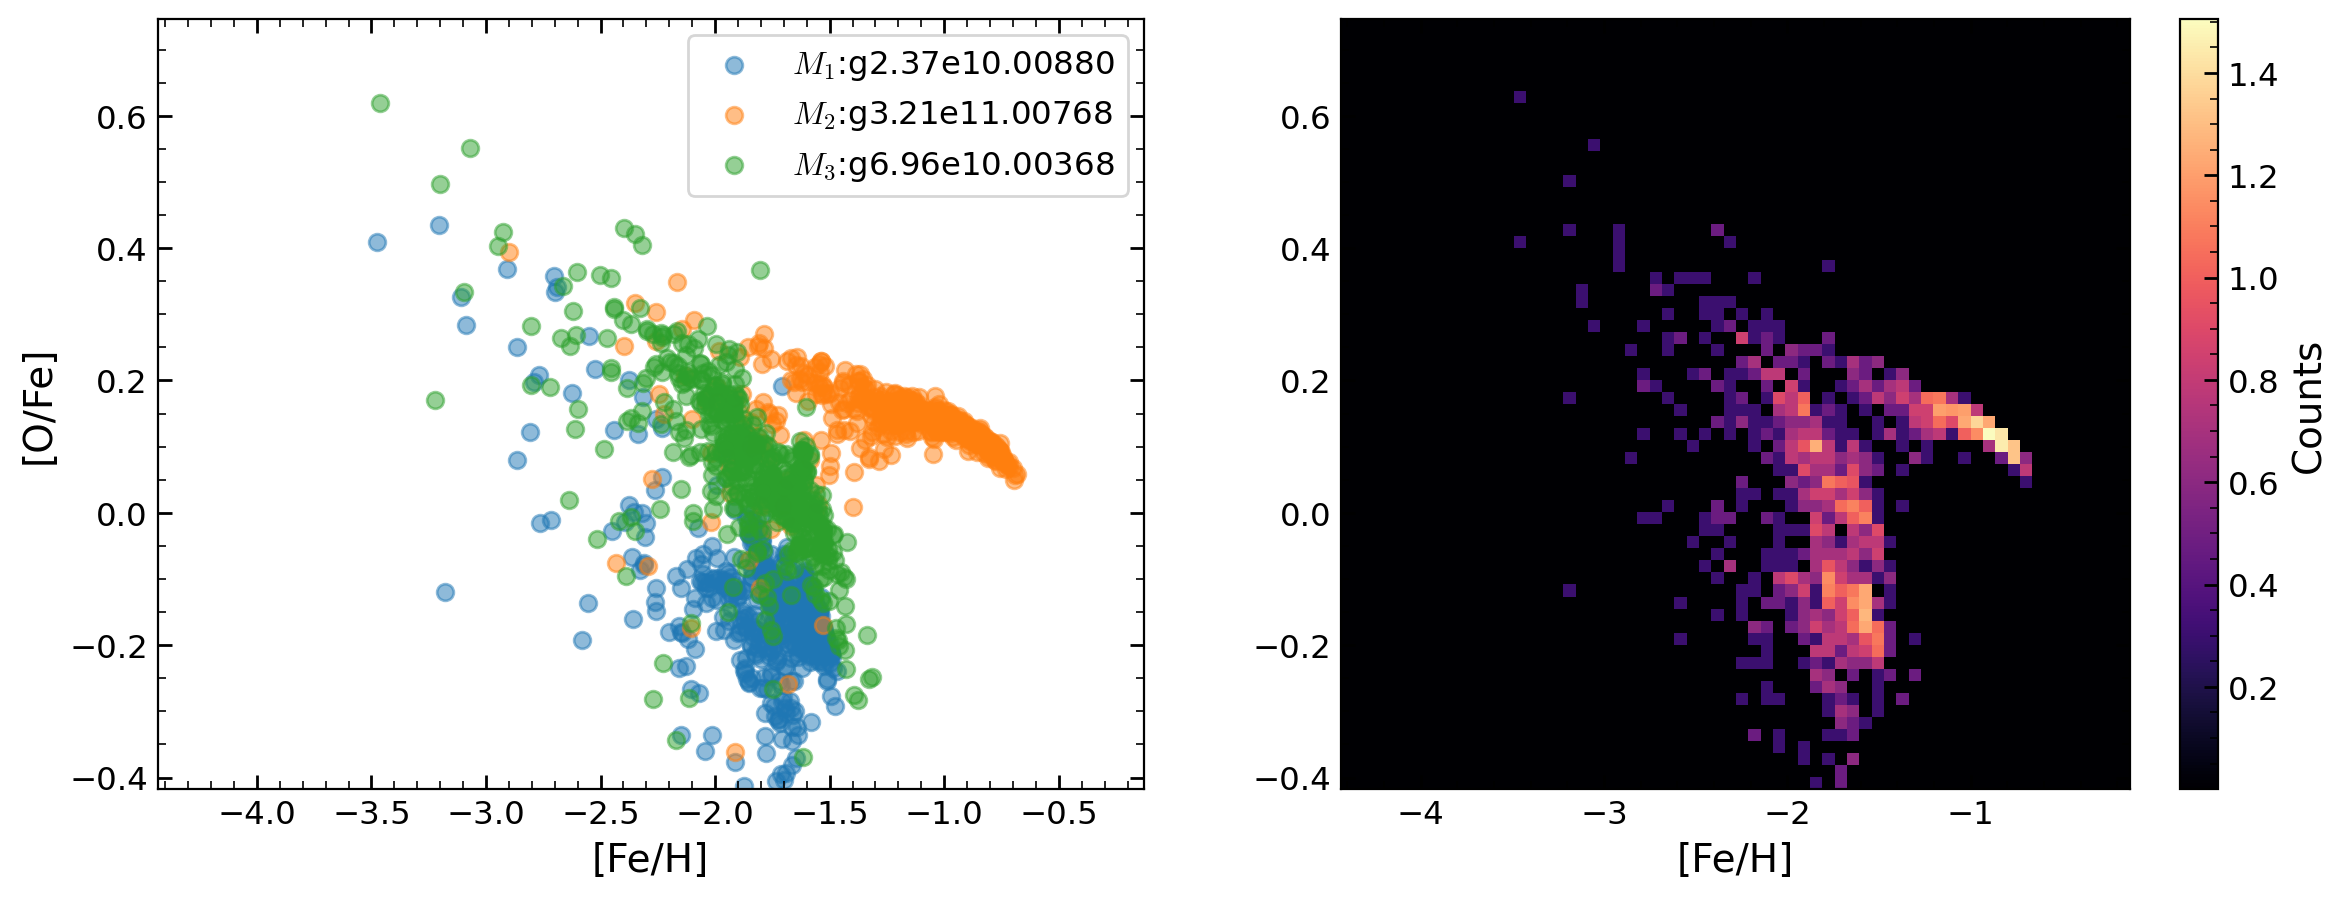

In [2]:
data = pd.read_parquet('../../../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameter=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])

data_to_plot_halos = pd.read_parquet('./halos_0.parquet')

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
for i, galaxy in enumerate(data_to_plot_halos['Galaxy_name'].unique()):
    observables =  data_to_plot_halos[data_to_plot_halos['Galaxy_name'] == galaxy]
    ax.scatter(observables['feh'], observables['ofe'], label=f'$M_{i+1}$:{galaxy}',alpha=0.5)
    ax.set_xlabel('[Fe/H]')   
    ax.set_ylabel('[O/Fe]')
    ax.set_xlim((min_feh, max_feh))
    ax.set_ylim((min_ofe, max_ofe))
    ax.legend()
ax = fig.add_subplot(122)
im = ax.imshow(np.load('x_0.npy').T, origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='magma')
ax.set_xlabel('[Fe/H]')   
# ax.set_ylabel('[O/Fe]')
cbar = fig.colorbar(im, ax=ax, label='Counts')
cbar.set_label('Counts', size=14)

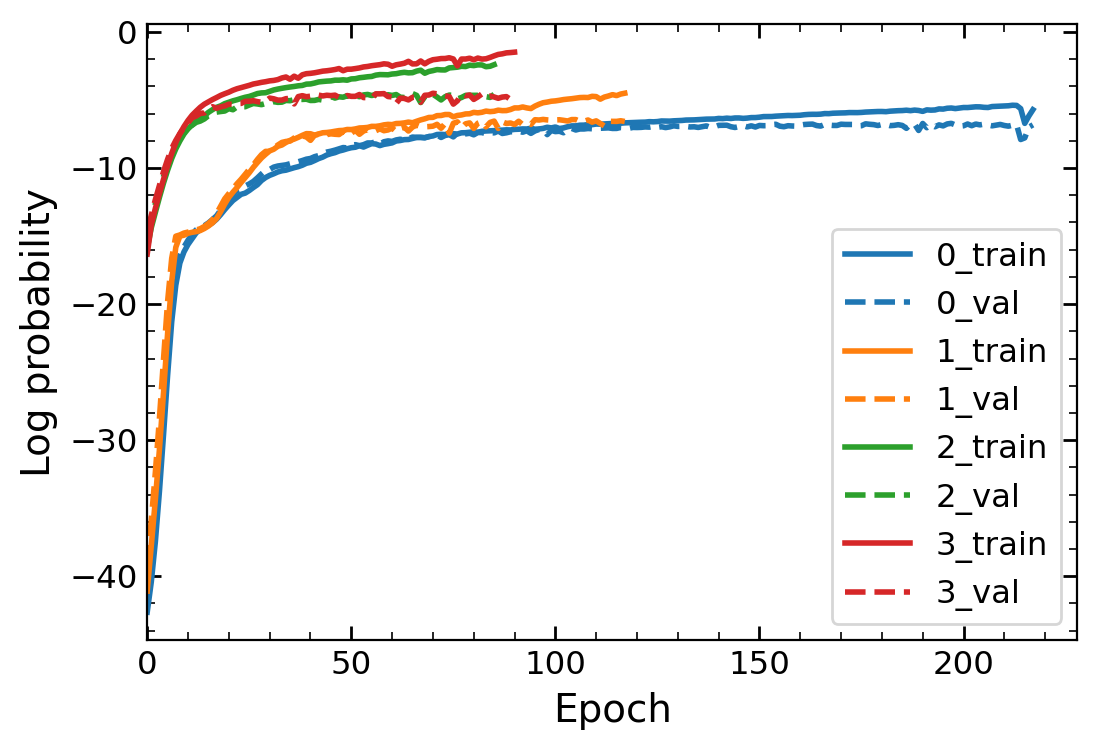

In [3]:
# Open the JSON file
with open('toy_NPE_summary.json', 'r') as f:
    # Load the data from the file
    summaries = json.load(f)
    
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [4]:
labels = [r'\log_{10}($M_{s, 1})\ [M_\odot]$', r'$\log_{10}(M_{s, 2})\ [M_\odot]$', r'$\log_{10}(M_{s, 3})\ [M_\odot]$', r'$\log_{10}(M_{DM, 1})\ [M_\odot]$', r'$\log_{10}(M_{DM, 2})\ [M_\odot]$', r'$\log_{10}(M_{DM, 3})\ [Gyr]$', r'$\tau_{1}\ [Gyr]$', r'$\tau_{2}\ [Gyr]$', r'$\tau_{3}\ [Gyr]$ ']

samples = {}
m = 'NPE'
with open(join('./', 'toy_NPE_posterior.pkl'), 'rb') as f:
    samples[m] = pickle.load(f)
posterior_samples = samples['NPE'].sample((5_000,), x=torch.from_numpy(np.load('./x_0.npy')).to('cuda'))

Drawing 237 posterior samples:   0%|          | 0/237 [00:00<?, ?it/s]

Drawing 342 posterior samples:   0%|          | 0/342 [00:00<?, ?it/s]

Drawing 2203 posterior samples:   0%|          | 0/2203 [00:00<?, ?it/s]

/export/home/vgiusepp/.local/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(


Drawing 2218 posterior samples:   0%|          | 0/2218 [00:00<?, ?it/s]

Drawing 249 posterior samples:   0%|          | 0/249 [00:00<?, ?it/s]

Drawing 356 posterior samples:   0%|          | 0/356 [00:00<?, ?it/s]

Drawing 2241 posterior samples:   0%|          | 0/2241 [00:00<?, ?it/s]

Drawing 2154 posterior samples:   0%|          | 0/2154 [00:00<?, ?it/s]

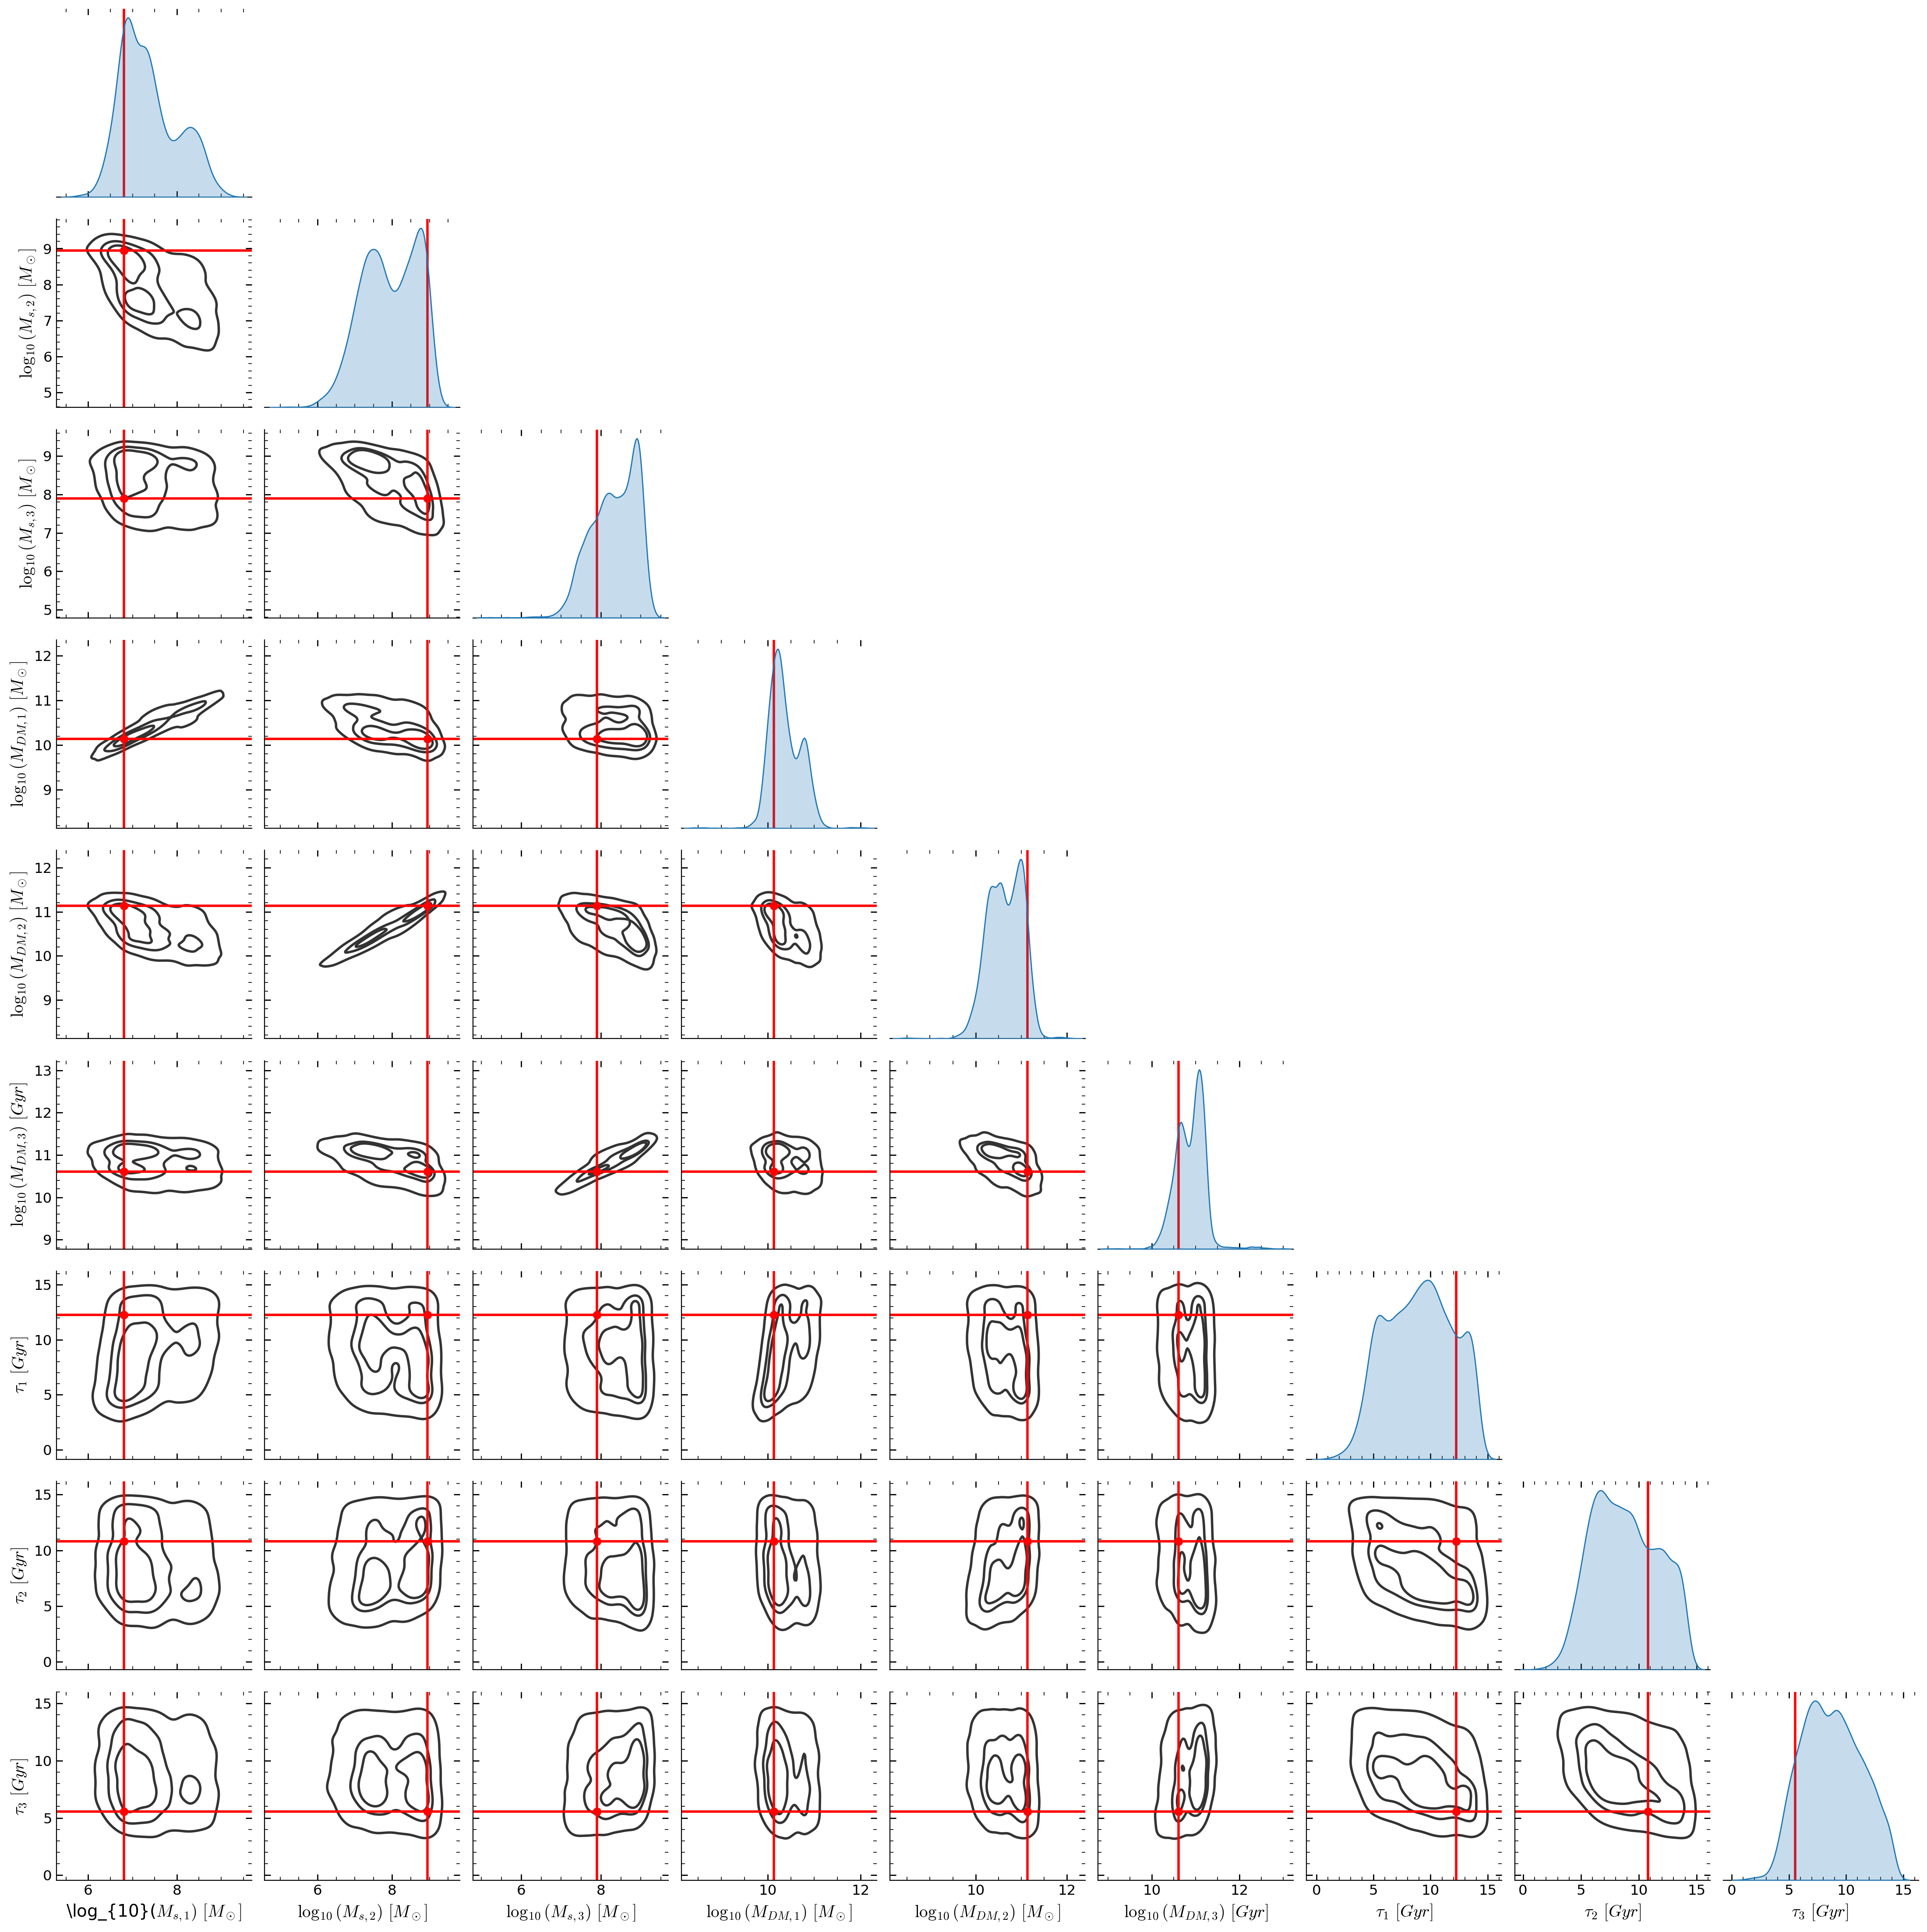

In [5]:
metric = PlotSinglePosterior(
    num_samples=5_000, sample_method='direct', 
    labels = labels,
    out_dir=None
)
fig = metric(
    posterior=samples[m],
    x_obs = torch.from_numpy(np.load('./x_0.npy')), theta_fid=torch.from_numpy(np.load('./theta_0.npy')),
)
fig.savefig('corner_2subhalos.png')

  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


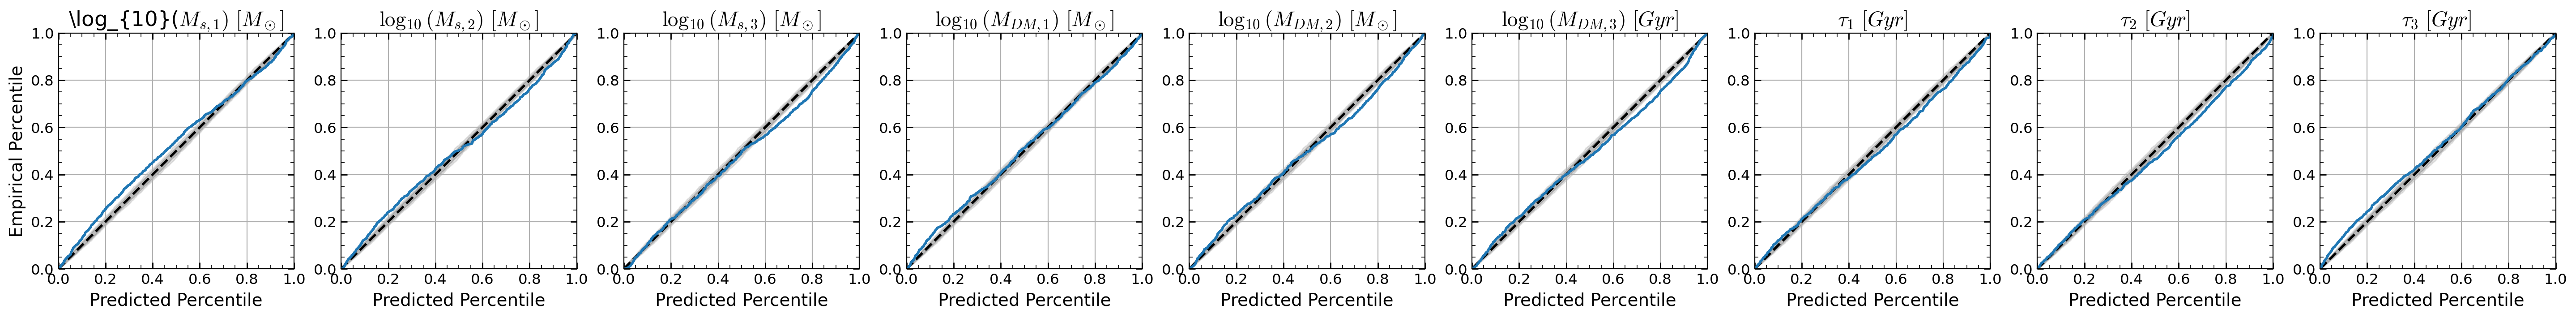

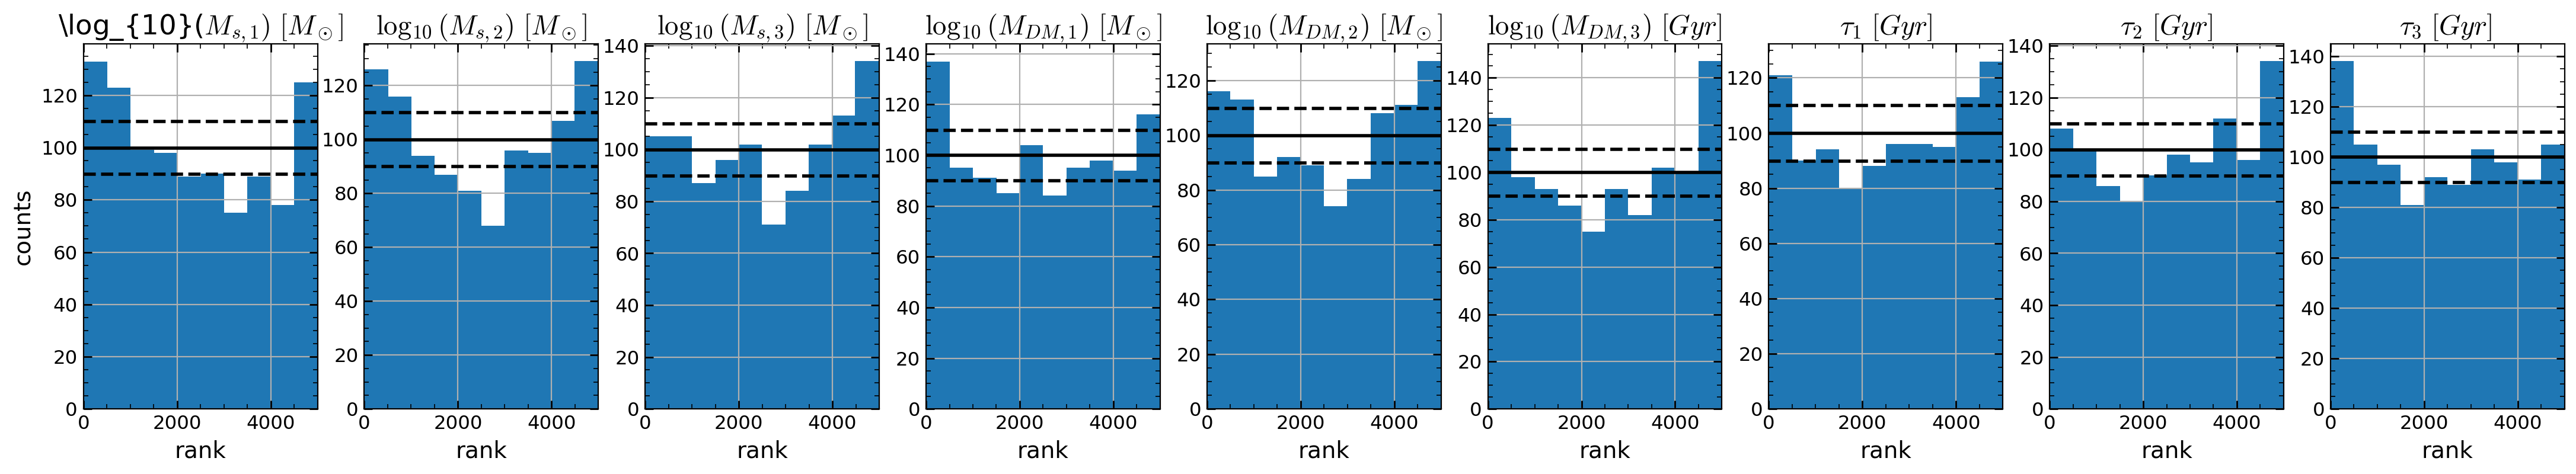

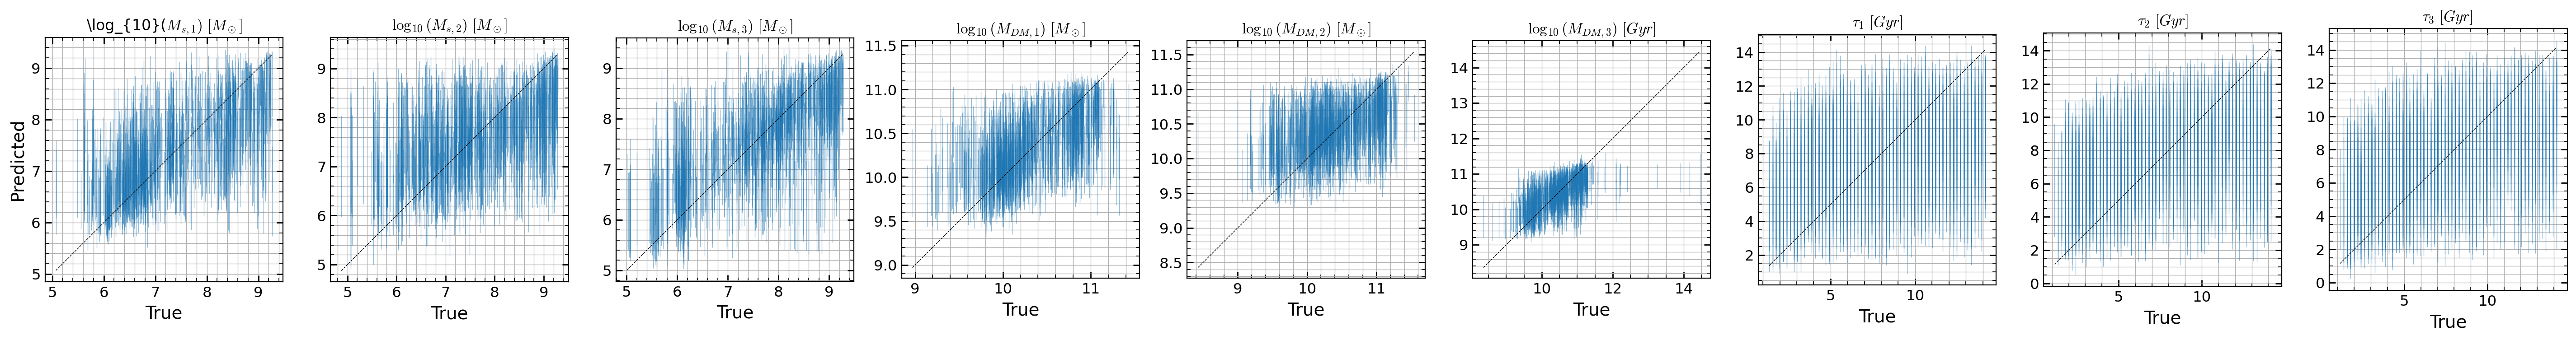

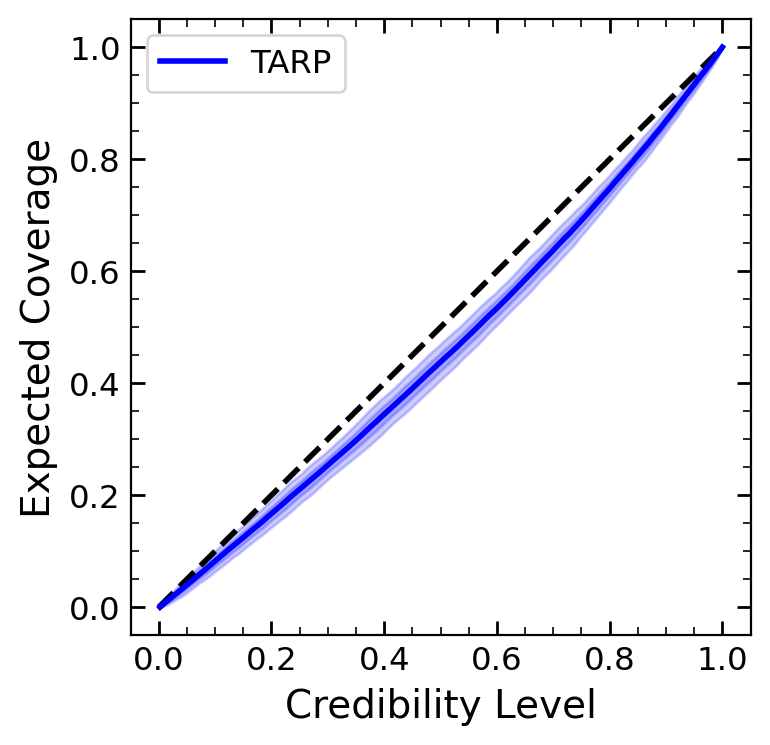

In [6]:
metric = PosteriorCoverage(
    num_samples=5000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=samples[m],
    x=torch.from_numpy(np.load('./x_test.npy')), theta=torch.from_numpy(np.load('./theta_test.npy'))
)
fig[3].savefig('coverage_2subhalos.png')

In [ ]:
from sbibm.metrics.c2st import c2st
from sbibm.metrics.mmd import mmd
theta_test = torch.from_numpy(np.load('./theta_test.npy')).to('cuda')
x_test = torch.from_numpy(np.load('./x_test.npy')).to('cuda')
posterior_mean = torch.zeros_like(theta_test)
posterior_std = torch.zeros_like(theta_test)
for i, x_0 in enumerate(x_test):
    posterior_mean[i] = samples['NPE'].sample((10_000,), x=x_0).mean(axis=0)
    posterior_std[i] = samples['NPE'].sample((10_000,), x=x_0).std(axis=0)

c2st_score = c2st(theta_test, posterior_samples)
mmd_score = mmd(theta_test, posterior_samples)

mre = ((theta_test - posterior_mean).abs() / theta_test.abs()).mean(axis=0)
r2 = 1 - ((theta_test - posterior_mean)**2).sum(axis=0) / ((theta_test - theta_test.mean(axis=0))**2).sum(axis=0)
mse = ((theta_test - posterior_mean)**2).mean(axis=0)
chi2 = ((theta_test - posterior_mean)**2 / posterior_std**2).mean(axis=0)



Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 724 posterior samples:   0%|          | 0/724 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4303 posterior samples:   0%|          | 0/4303 [00:00<?, ?it/s]

Drawing 4574 posterior samples:   0%|          | 0/4574 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4322 posterior samples:   0%|          | 0/4322 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4322 posterior samples:   0%|          | 0/4322 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4524 posterior samples:   0%|          | 0/4524 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4312 posterior samples:   0%|          | 0/4312 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 545 posterior samples:   0%|          | 0/545 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4286 posterior samples:   0%|          | 0/4286 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 697 posterior samples:   0%|          | 0/697 [00:00<?, ?it/s]

Drawing 4256 posterior samples:   0%|          | 0/4256 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 456 posterior samples:   0%|          | 0/456 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4322 posterior samples:   0%|          | 0/4322 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4484 posterior samples:   0%|          | 0/4484 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 740 posterior samples:   0%|          | 0/740 [00:00<?, ?it/s]

Drawing 4244 posterior samples:   0%|          | 0/4244 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4548 posterior samples:   0%|          | 0/4548 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4320 posterior samples:   0%|          | 0/4320 [00:00<?, ?it/s]

Drawing 4566 posterior samples:   0%|          | 0/4566 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4352 posterior samples:   0%|          | 0/4352 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 450 posterior samples:   0%|          | 0/450 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4289 posterior samples:   0%|          | 0/4289 [00:00<?, ?it/s]

Drawing 4595 posterior samples:   0%|          | 0/4595 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4292 posterior samples:   0%|          | 0/4292 [00:00<?, ?it/s]

Drawing 4566 posterior samples:   0%|          | 0/4566 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4336 posterior samples:   0%|          | 0/4336 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4560 posterior samples:   0%|          | 0/4560 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4523 posterior samples:   0%|          | 0/4523 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 705 posterior samples:   0%|          | 0/705 [00:00<?, ?it/s]

Drawing 4317 posterior samples:   0%|          | 0/4317 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 707 posterior samples:   0%|          | 0/707 [00:00<?, ?it/s]

Drawing 4322 posterior samples:   0%|          | 0/4322 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4545 posterior samples:   0%|          | 0/4545 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 716 posterior samples:   0%|          | 0/716 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 698 posterior samples:   0%|          | 0/698 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 705 posterior samples:   0%|          | 0/705 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 703 posterior samples:   0%|          | 0/703 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4314 posterior samples:   0%|          | 0/4314 [00:00<?, ?it/s]

Drawing 4554 posterior samples:   0%|          | 0/4554 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 4325 posterior samples:   0%|          | 0/4325 [00:00<?, ?it/s]

Drawing 445 posterior samples:   0%|          | 0/445 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4567 posterior samples:   0%|          | 0/4567 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 709 posterior samples:   0%|          | 0/709 [00:00<?, ?it/s]

Drawing 4327 posterior samples:   0%|          | 0/4327 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4581 posterior samples:   0%|          | 0/4581 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 704 posterior samples:   0%|          | 0/704 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4336 posterior samples:   0%|          | 0/4336 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4352 posterior samples:   0%|          | 0/4352 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4291 posterior samples:   0%|          | 0/4291 [00:00<?, ?it/s]

Drawing 4553 posterior samples:   0%|          | 0/4553 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4297 posterior samples:   0%|          | 0/4297 [00:00<?, ?it/s]

Drawing 4561 posterior samples:   0%|          | 0/4561 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 712 posterior samples:   0%|          | 0/712 [00:00<?, ?it/s]

Drawing 4294 posterior samples:   0%|          | 0/4294 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4276 posterior samples:   0%|          | 0/4276 [00:00<?, ?it/s]

Drawing 4574 posterior samples:   0%|          | 0/4574 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4326 posterior samples:   0%|          | 0/4326 [00:00<?, ?it/s]

Drawing 4544 posterior samples:   0%|          | 0/4544 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4543 posterior samples:   0%|          | 0/4543 [00:00<?, ?it/s]

Drawing 444 posterior samples:   0%|          | 0/444 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4282 posterior samples:   0%|          | 0/4282 [00:00<?, ?it/s]

Drawing 4553 posterior samples:   0%|          | 0/4553 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 697 posterior samples:   0%|          | 0/697 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4299 posterior samples:   0%|          | 0/4299 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 444 posterior samples:   0%|          | 0/444 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4319 posterior samples:   0%|          | 0/4319 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 704 posterior samples:   0%|          | 0/704 [00:00<?, ?it/s]

Drawing 4326 posterior samples:   0%|          | 0/4326 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 547 posterior samples:   0%|          | 0/547 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 684 posterior samples:   0%|          | 0/684 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4275 posterior samples:   0%|          | 0/4275 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 436 posterior samples:   0%|          | 0/436 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4531 posterior samples:   0%|          | 0/4531 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4544 posterior samples:   0%|          | 0/4544 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4287 posterior samples:   0%|          | 0/4287 [00:00<?, ?it/s]

Drawing 4551 posterior samples:   0%|          | 0/4551 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4309 posterior samples:   0%|          | 0/4309 [00:00<?, ?it/s]

Drawing 4580 posterior samples:   0%|          | 0/4580 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 538 posterior samples:   0%|          | 0/538 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4312 posterior samples:   0%|          | 0/4312 [00:00<?, ?it/s]

Drawing 4548 posterior samples:   0%|          | 0/4548 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 710 posterior samples:   0%|          | 0/710 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4322 posterior samples:   0%|          | 0/4322 [00:00<?, ?it/s]

Drawing 4567 posterior samples:   0%|          | 0/4567 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4282 posterior samples:   0%|          | 0/4282 [00:00<?, ?it/s]

Drawing 4573 posterior samples:   0%|          | 0/4573 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4484 posterior samples:   0%|          | 0/4484 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4314 posterior samples:   0%|          | 0/4314 [00:00<?, ?it/s]

Drawing 4558 posterior samples:   0%|          | 0/4558 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 448 posterior samples:   0%|          | 0/448 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4274 posterior samples:   0%|          | 0/4274 [00:00<?, ?it/s]

Drawing 4523 posterior samples:   0%|          | 0/4523 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4303 posterior samples:   0%|          | 0/4303 [00:00<?, ?it/s]

Drawing 4528 posterior samples:   0%|          | 0/4528 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4294 posterior samples:   0%|          | 0/4294 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 704 posterior samples:   0%|          | 0/704 [00:00<?, ?it/s]

Drawing 4320 posterior samples:   0%|          | 0/4320 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4220 posterior samples:   0%|          | 0/4220 [00:00<?, ?it/s]

Drawing 4607 posterior samples:   0%|          | 0/4607 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 684 posterior samples:   0%|          | 0/684 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 544 posterior samples:   0%|          | 0/544 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4255 posterior samples:   0%|          | 0/4255 [00:00<?, ?it/s]

Drawing 4549 posterior samples:   0%|          | 0/4549 [00:00<?, ?it/s]

Drawing 540 posterior samples:   0%|          | 0/540 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 450 posterior samples:   0%|          | 0/450 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 684 posterior samples:   0%|          | 0/684 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 719 posterior samples:   0%|          | 0/719 [00:00<?, ?it/s]

Drawing 4286 posterior samples:   0%|          | 0/4286 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4541 posterior samples:   0%|          | 0/4541 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4493 posterior samples:   0%|          | 0/4493 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4318 posterior samples:   0%|          | 0/4318 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4555 posterior samples:   0%|          | 0/4555 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 703 posterior samples:   0%|          | 0/703 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4568 posterior samples:   0%|          | 0/4568 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 712 posterior samples:   0%|          | 0/712 [00:00<?, ?it/s]

Drawing 4274 posterior samples:   0%|          | 0/4274 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 694 posterior samples:   0%|          | 0/694 [00:00<?, ?it/s]

Drawing 4326 posterior samples:   0%|          | 0/4326 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 610 posterior samples:   0%|          | 0/610 [00:00<?, ?it/s]

Drawing 4302 posterior samples:   0%|          | 0/4302 [00:00<?, ?it/s]

Drawing 4567 posterior samples:   0%|          | 0/4567 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4321 posterior samples:   0%|          | 0/4321 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4311 posterior samples:   0%|          | 0/4311 [00:00<?, ?it/s]

Drawing 4559 posterior samples:   0%|          | 0/4559 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 698 posterior samples:   0%|          | 0/698 [00:00<?, ?it/s]

Drawing 4319 posterior samples:   0%|          | 0/4319 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 423 posterior samples:   0%|          | 0/423 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4547 posterior samples:   0%|          | 0/4547 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4548 posterior samples:   0%|          | 0/4548 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4321 posterior samples:   0%|          | 0/4321 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4529 posterior samples:   0%|          | 0/4529 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4319 posterior samples:   0%|          | 0/4319 [00:00<?, ?it/s]

Drawing 4553 posterior samples:   0%|          | 0/4553 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 692 posterior samples:   0%|          | 0/692 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4311 posterior samples:   0%|          | 0/4311 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4545 posterior samples:   0%|          | 0/4545 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 700 posterior samples:   0%|          | 0/700 [00:00<?, ?it/s]

Drawing 4294 posterior samples:   0%|          | 0/4294 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 417 posterior samples:   0%|          | 0/417 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4533 posterior samples:   0%|          | 0/4533 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4299 posterior samples:   0%|          | 0/4299 [00:00<?, ?it/s]

Drawing 4563 posterior samples:   0%|          | 0/4563 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4311 posterior samples:   0%|          | 0/4311 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 441 posterior samples:   0%|          | 0/441 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 582 posterior samples:   0%|          | 0/582 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 699 posterior samples:   0%|          | 0/699 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 448 posterior samples:   0%|          | 0/448 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4508 posterior samples:   0%|          | 0/4508 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 700 posterior samples:   0%|          | 0/700 [00:00<?, ?it/s]

Drawing 4298 posterior samples:   0%|          | 0/4298 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4319 posterior samples:   0%|          | 0/4319 [00:00<?, ?it/s]

Drawing 4544 posterior samples:   0%|          | 0/4544 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 712 posterior samples:   0%|          | 0/712 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4302 posterior samples:   0%|          | 0/4302 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 450 posterior samples:   0%|          | 0/450 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4312 posterior samples:   0%|          | 0/4312 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 703 posterior samples:   0%|          | 0/703 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4299 posterior samples:   0%|          | 0/4299 [00:00<?, ?it/s]

Drawing 4545 posterior samples:   0%|          | 0/4545 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 701 posterior samples:   0%|          | 0/701 [00:00<?, ?it/s]

Drawing 4300 posterior samples:   0%|          | 0/4300 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 700 posterior samples:   0%|          | 0/700 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 4524 posterior samples:   0%|          | 0/4524 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 701 posterior samples:   0%|          | 0/701 [00:00<?, ?it/s]

Drawing 4319 posterior samples:   0%|          | 0/4319 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 713 posterior samples:   0%|          | 0/713 [00:00<?, ?it/s]

Drawing 4268 posterior samples:   0%|          | 0/4268 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 545 posterior samples:   0%|          | 0/545 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4508 posterior samples:   0%|          | 0/4508 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 700 posterior samples:   0%|          | 0/700 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4314 posterior samples:   0%|          | 0/4314 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4508 posterior samples:   0%|          | 0/4508 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4321 posterior samples:   0%|          | 0/4321 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 703 posterior samples:   0%|          | 0/703 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 449 posterior samples:   0%|          | 0/449 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4581 posterior samples:   0%|          | 0/4581 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 711 posterior samples:   0%|          | 0/711 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 561 posterior samples:   0%|          | 0/561 [00:00<?, ?it/s]

Drawing 694 posterior samples:   0%|          | 0/694 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4294 posterior samples:   0%|          | 0/4294 [00:00<?, ?it/s]

Drawing 4551 posterior samples:   0%|          | 0/4551 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4320 posterior samples:   0%|          | 0/4320 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4309 posterior samples:   0%|          | 0/4309 [00:00<?, ?it/s]

Drawing 4549 posterior samples:   0%|          | 0/4549 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4276 posterior samples:   0%|          | 0/4276 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 453 posterior samples:   0%|          | 0/453 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4547 posterior samples:   0%|          | 0/4547 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 610 posterior samples:   0%|          | 0/610 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4508 posterior samples:   0%|          | 0/4508 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4533 posterior samples:   0%|          | 0/4533 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 704 posterior samples:   0%|          | 0/704 [00:00<?, ?it/s]

Drawing 4368 posterior samples:   0%|          | 0/4368 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 695 posterior samples:   0%|          | 0/695 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 432 posterior samples:   0%|          | 0/432 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4221 posterior samples:   0%|          | 0/4221 [00:00<?, ?it/s]

Drawing 4585 posterior samples:   0%|          | 0/4585 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4514 posterior samples:   0%|          | 0/4514 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4550 posterior samples:   0%|          | 0/4550 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4547 posterior samples:   0%|          | 0/4547 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4558 posterior samples:   0%|          | 0/4558 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 592 posterior samples:   0%|          | 0/592 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4552 posterior samples:   0%|          | 0/4552 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 449 posterior samples:   0%|          | 0/449 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4296 posterior samples:   0%|          | 0/4296 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 684 posterior samples:   0%|          | 0/684 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4352 posterior samples:   0%|          | 0/4352 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 591 posterior samples:   0%|          | 0/591 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 701 posterior samples:   0%|          | 0/701 [00:00<?, ?it/s]

Drawing 4286 posterior samples:   0%|          | 0/4286 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4557 posterior samples:   0%|          | 0/4557 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4324 posterior samples:   0%|          | 0/4324 [00:00<?, ?it/s]

Drawing 4563 posterior samples:   0%|          | 0/4563 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 687 posterior samples:   0%|          | 0/687 [00:00<?, ?it/s]

Drawing 4306 posterior samples:   0%|          | 0/4306 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 4336 posterior samples:   0%|          | 0/4336 [00:00<?, ?it/s]

Drawing 4584 posterior samples:   0%|          | 0/4584 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 700 posterior samples:   0%|          | 0/700 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4281 posterior samples:   0%|          | 0/4281 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4317 posterior samples:   0%|          | 0/4317 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 4368 posterior samples:   0%|          | 0/4368 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4287 posterior samples:   0%|          | 0/4287 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4560 posterior samples:   0%|          | 0/4560 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 699 posterior samples:   0%|          | 0/699 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 449 posterior samples:   0%|          | 0/449 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4572 posterior samples:   0%|          | 0/4572 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4411 posterior samples:   0%|          | 0/4411 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 712 posterior samples:   0%|          | 0/712 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4531 posterior samples:   0%|          | 0/4531 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4561 posterior samples:   0%|          | 0/4561 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 610 posterior samples:   0%|          | 0/610 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 714 posterior samples:   0%|          | 0/714 [00:00<?, ?it/s]

Drawing 4321 posterior samples:   0%|          | 0/4321 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 424 posterior samples:   0%|          | 0/424 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4539 posterior samples:   0%|          | 0/4539 [00:00<?, ?it/s]

Drawing 449 posterior samples:   0%|          | 0/449 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4552 posterior samples:   0%|          | 0/4552 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4493 posterior samples:   0%|          | 0/4493 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 589 posterior samples:   0%|          | 0/589 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4272 posterior samples:   0%|          | 0/4272 [00:00<?, ?it/s]

Drawing 4580 posterior samples:   0%|          | 0/4580 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 563 posterior samples:   0%|          | 0/563 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 703 posterior samples:   0%|          | 0/703 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 697 posterior samples:   0%|          | 0/697 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4303 posterior samples:   0%|          | 0/4303 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 692 posterior samples:   0%|          | 0/692 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4289 posterior samples:   0%|          | 0/4289 [00:00<?, ?it/s]

Drawing 4544 posterior samples:   0%|          | 0/4544 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4239 posterior samples:   0%|          | 0/4239 [00:00<?, ?it/s]

Drawing 4584 posterior samples:   0%|          | 0/4584 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4323 posterior samples:   0%|          | 0/4323 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 608 posterior samples:   0%|          | 0/608 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4549 posterior samples:   0%|          | 0/4549 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4514 posterior samples:   0%|          | 0/4514 [00:00<?, ?it/s]

Drawing 437 posterior samples:   0%|          | 0/437 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4352 posterior samples:   0%|          | 0/4352 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 542 posterior samples:   0%|          | 0/542 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 447 posterior samples:   0%|          | 0/447 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4484 posterior samples:   0%|          | 0/4484 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4311 posterior samples:   0%|          | 0/4311 [00:00<?, ?it/s]

Drawing 4590 posterior samples:   0%|          | 0/4590 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4552 posterior samples:   0%|          | 0/4552 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4305 posterior samples:   0%|          | 0/4305 [00:00<?, ?it/s]

Drawing 4577 posterior samples:   0%|          | 0/4577 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 453 posterior samples:   0%|          | 0/453 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 456 posterior samples:   0%|          | 0/456 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4319 posterior samples:   0%|          | 0/4319 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 540 posterior samples:   0%|          | 0/540 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 711 posterior samples:   0%|          | 0/711 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 610 posterior samples:   0%|          | 0/610 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4548 posterior samples:   0%|          | 0/4548 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 692 posterior samples:   0%|          | 0/692 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4411 posterior samples:   0%|          | 0/4411 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 705 posterior samples:   0%|          | 0/705 [00:00<?, ?it/s]

Drawing 4274 posterior samples:   0%|          | 0/4274 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4312 posterior samples:   0%|          | 0/4312 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4300 posterior samples:   0%|          | 0/4300 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 707 posterior samples:   0%|          | 0/707 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4311 posterior samples:   0%|          | 0/4311 [00:00<?, ?it/s]

Drawing 4574 posterior samples:   0%|          | 0/4574 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4499 posterior samples:   0%|          | 0/4499 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4314 posterior samples:   0%|          | 0/4314 [00:00<?, ?it/s]

Drawing 4556 posterior samples:   0%|          | 0/4556 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4243 posterior samples:   0%|          | 0/4243 [00:00<?, ?it/s]

Drawing 4590 posterior samples:   0%|          | 0/4590 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4322 posterior samples:   0%|          | 0/4322 [00:00<?, ?it/s]

Drawing 4528 posterior samples:   0%|          | 0/4528 [00:00<?, ?it/s]

Drawing 444 posterior samples:   0%|          | 0/444 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4255 posterior samples:   0%|          | 0/4255 [00:00<?, ?it/s]

Drawing 4583 posterior samples:   0%|          | 0/4583 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4325 posterior samples:   0%|          | 0/4325 [00:00<?, ?it/s]

Drawing 4539 posterior samples:   0%|          | 0/4539 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4336 posterior samples:   0%|          | 0/4336 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 588 posterior samples:   0%|          | 0/588 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4309 posterior samples:   0%|          | 0/4309 [00:00<?, ?it/s]

Drawing 4543 posterior samples:   0%|          | 0/4543 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4289 posterior samples:   0%|          | 0/4289 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 449 posterior samples:   0%|          | 0/449 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4523 posterior samples:   0%|          | 0/4523 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4569 posterior samples:   0%|          | 0/4569 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4523 posterior samples:   0%|          | 0/4523 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4551 posterior samples:   0%|          | 0/4551 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4299 posterior samples:   0%|          | 0/4299 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4298 posterior samples:   0%|          | 0/4298 [00:00<?, ?it/s]

Drawing 4555 posterior samples:   0%|          | 0/4555 [00:00<?, ?it/s]

Drawing 562 posterior samples:   0%|          | 0/562 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4302 posterior samples:   0%|          | 0/4302 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4304 posterior samples:   0%|          | 0/4304 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 587 posterior samples:   0%|          | 0/587 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4514 posterior samples:   0%|          | 0/4514 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4326 posterior samples:   0%|          | 0/4326 [00:00<?, ?it/s]

Drawing 4552 posterior samples:   0%|          | 0/4552 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4288 posterior samples:   0%|          | 0/4288 [00:00<?, ?it/s]

Drawing 4539 posterior samples:   0%|          | 0/4539 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4305 posterior samples:   0%|          | 0/4305 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 705 posterior samples:   0%|          | 0/705 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 452 posterior samples:   0%|          | 0/452 [00:00<?, ?it/s]

Drawing 708 posterior samples:   0%|          | 0/708 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 536 posterior samples:   0%|          | 0/536 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4323 posterior samples:   0%|          | 0/4323 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4300 posterior samples:   0%|          | 0/4300 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4317 posterior samples:   0%|          | 0/4317 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 602 posterior samples:   0%|          | 0/602 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4310 posterior samples:   0%|          | 0/4310 [00:00<?, ?it/s]

Drawing 4529 posterior samples:   0%|          | 0/4529 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4309 posterior samples:   0%|          | 0/4309 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4298 posterior samples:   0%|          | 0/4298 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4508 posterior samples:   0%|          | 0/4508 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4195 posterior samples:   0%|          | 0/4195 [00:00<?, ?it/s]

Drawing 4629 posterior samples:   0%|          | 0/4629 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 608 posterior samples:   0%|          | 0/608 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4537 posterior samples:   0%|          | 0/4537 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4301 posterior samples:   0%|          | 0/4301 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 705 posterior samples:   0%|          | 0/705 [00:00<?, ?it/s]

Drawing 4296 posterior samples:   0%|          | 0/4296 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4312 posterior samples:   0%|          | 0/4312 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4529 posterior samples:   0%|          | 0/4529 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4514 posterior samples:   0%|          | 0/4514 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4326 posterior samples:   0%|          | 0/4326 [00:00<?, ?it/s]

Drawing 4557 posterior samples:   0%|          | 0/4557 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4292 posterior samples:   0%|          | 0/4292 [00:00<?, ?it/s]

Drawing 4579 posterior samples:   0%|          | 0/4579 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4300 posterior samples:   0%|          | 0/4300 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4318 posterior samples:   0%|          | 0/4318 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 452 posterior samples:   0%|          | 0/452 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4299 posterior samples:   0%|          | 0/4299 [00:00<?, ?it/s]

Drawing 4531 posterior samples:   0%|          | 0/4531 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 707 posterior samples:   0%|          | 0/707 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4273 posterior samples:   0%|          | 0/4273 [00:00<?, ?it/s]

Drawing 4582 posterior samples:   0%|          | 0/4582 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4279 posterior samples:   0%|          | 0/4279 [00:00<?, ?it/s]

Drawing 4562 posterior samples:   0%|          | 0/4562 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 536 posterior samples:   0%|          | 0/536 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4279 posterior samples:   0%|          | 0/4279 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 4565 posterior samples:   0%|          | 0/4565 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 598 posterior samples:   0%|          | 0/598 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4541 posterior samples:   0%|          | 0/4541 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4307 posterior samples:   0%|          | 0/4307 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4336 posterior samples:   0%|          | 0/4336 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4368 posterior samples:   0%|          | 0/4368 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4327 posterior samples:   0%|          | 0/4327 [00:00<?, ?it/s]

Drawing 4531 posterior samples:   0%|          | 0/4531 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 714 posterior samples:   0%|          | 0/714 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 450 posterior samples:   0%|          | 0/450 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 700 posterior samples:   0%|          | 0/700 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4323 posterior samples:   0%|          | 0/4323 [00:00<?, ?it/s]

Drawing 4543 posterior samples:   0%|          | 0/4543 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 449 posterior samples:   0%|          | 0/449 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4309 posterior samples:   0%|          | 0/4309 [00:00<?, ?it/s]

Drawing 4540 posterior samples:   0%|          | 0/4540 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4294 posterior samples:   0%|          | 0/4294 [00:00<?, ?it/s]

Drawing 4539 posterior samples:   0%|          | 0/4539 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 697 posterior samples:   0%|          | 0/697 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4327 posterior samples:   0%|          | 0/4327 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4499 posterior samples:   0%|          | 0/4499 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 700 posterior samples:   0%|          | 0/700 [00:00<?, ?it/s]

Drawing 4246 posterior samples:   0%|          | 0/4246 [00:00<?, ?it/s]

Drawing 4569 posterior samples:   0%|          | 0/4569 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 439 posterior samples:   0%|          | 0/439 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 4559 posterior samples:   0%|          | 0/4559 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4547 posterior samples:   0%|          | 0/4547 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 536 posterior samples:   0%|          | 0/536 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4324 posterior samples:   0%|          | 0/4324 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4264 posterior samples:   0%|          | 0/4264 [00:00<?, ?it/s]

Drawing 4582 posterior samples:   0%|          | 0/4582 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4301 posterior samples:   0%|          | 0/4301 [00:00<?, ?it/s]

Drawing 4587 posterior samples:   0%|          | 0/4587 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4276 posterior samples:   0%|          | 0/4276 [00:00<?, ?it/s]

Drawing 4571 posterior samples:   0%|          | 0/4571 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4547 posterior samples:   0%|          | 0/4547 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 704 posterior samples:   0%|          | 0/704 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 698 posterior samples:   0%|          | 0/698 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 429 posterior samples:   0%|          | 0/429 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4299 posterior samples:   0%|          | 0/4299 [00:00<?, ?it/s]

Drawing 4592 posterior samples:   0%|          | 0/4592 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4277 posterior samples:   0%|          | 0/4277 [00:00<?, ?it/s]

Drawing 4562 posterior samples:   0%|          | 0/4562 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 445 posterior samples:   0%|          | 0/445 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4217 posterior samples:   0%|          | 0/4217 [00:00<?, ?it/s]

Drawing 4588 posterior samples:   0%|          | 0/4588 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4320 posterior samples:   0%|          | 0/4320 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

Drawing 684 posterior samples:   0%|          | 0/684 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4524 posterior samples:   0%|          | 0/4524 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4312 posterior samples:   0%|          | 0/4312 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 695 posterior samples:   0%|          | 0/695 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4523 posterior samples:   0%|          | 0/4523 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 579 posterior samples:   0%|          | 0/579 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4602 posterior samples:   0%|          | 0/4602 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4541 posterior samples:   0%|          | 0/4541 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4309 posterior samples:   0%|          | 0/4309 [00:00<?, ?it/s]

Drawing 4570 posterior samples:   0%|          | 0/4570 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4575 posterior samples:   0%|          | 0/4575 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 703 posterior samples:   0%|          | 0/703 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4281 posterior samples:   0%|          | 0/4281 [00:00<?, ?it/s]

Drawing 4594 posterior samples:   0%|          | 0/4594 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4540 posterior samples:   0%|          | 0/4540 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4559 posterior samples:   0%|          | 0/4559 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4327 posterior samples:   0%|          | 0/4327 [00:00<?, ?it/s]

Drawing 4568 posterior samples:   0%|          | 0/4568 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 604 posterior samples:   0%|          | 0/604 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4368 posterior samples:   0%|          | 0/4368 [00:00<?, ?it/s]

Drawing 4550 posterior samples:   0%|          | 0/4550 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4287 posterior samples:   0%|          | 0/4287 [00:00<?, ?it/s]

Drawing 4559 posterior samples:   0%|          | 0/4559 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 701 posterior samples:   0%|          | 0/701 [00:00<?, ?it/s]

Drawing 4324 posterior samples:   0%|          | 0/4324 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 456 posterior samples:   0%|          | 0/456 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4276 posterior samples:   0%|          | 0/4276 [00:00<?, ?it/s]

Drawing 4593 posterior samples:   0%|          | 0/4593 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 535 posterior samples:   0%|          | 0/535 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4251 posterior samples:   0%|          | 0/4251 [00:00<?, ?it/s]

Drawing 4568 posterior samples:   0%|          | 0/4568 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4352 posterior samples:   0%|          | 0/4352 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 700 posterior samples:   0%|          | 0/700 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 700 posterior samples:   0%|          | 0/700 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 537 posterior samples:   0%|          | 0/537 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 456 posterior samples:   0%|          | 0/456 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4312 posterior samples:   0%|          | 0/4312 [00:00<?, ?it/s]

Drawing 4514 posterior samples:   0%|          | 0/4514 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 713 posterior samples:   0%|          | 0/713 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4292 posterior samples:   0%|          | 0/4292 [00:00<?, ?it/s]

Drawing 4611 posterior samples:   0%|          | 0/4611 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4508 posterior samples:   0%|          | 0/4508 [00:00<?, ?it/s]

Drawing 414 posterior samples:   0%|          | 0/414 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 545 posterior samples:   0%|          | 0/545 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4321 posterior samples:   0%|          | 0/4321 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 695 posterior samples:   0%|          | 0/695 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 604 posterior samples:   0%|          | 0/604 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4253 posterior samples:   0%|          | 0/4253 [00:00<?, ?it/s]

Drawing 4592 posterior samples:   0%|          | 0/4592 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4553 posterior samples:   0%|          | 0/4553 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 694 posterior samples:   0%|          | 0/694 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 453 posterior samples:   0%|          | 0/453 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4325 posterior samples:   0%|          | 0/4325 [00:00<?, ?it/s]

Drawing 4568 posterior samples:   0%|          | 0/4568 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 701 posterior samples:   0%|          | 0/701 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4499 posterior samples:   0%|          | 0/4499 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4323 posterior samples:   0%|          | 0/4323 [00:00<?, ?it/s]

Drawing 4524 posterior samples:   0%|          | 0/4524 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4248 posterior samples:   0%|          | 0/4248 [00:00<?, ?it/s]

Drawing 4630 posterior samples:   0%|          | 0/4630 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 717 posterior samples:   0%|          | 0/717 [00:00<?, ?it/s]

Drawing 4320 posterior samples:   0%|          | 0/4320 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 701 posterior samples:   0%|          | 0/701 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4539 posterior samples:   0%|          | 0/4539 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 706 posterior samples:   0%|          | 0/706 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4311 posterior samples:   0%|          | 0/4311 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4291 posterior samples:   0%|          | 0/4291 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4533 posterior samples:   0%|          | 0/4533 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4300 posterior samples:   0%|          | 0/4300 [00:00<?, ?it/s]

Drawing 4551 posterior samples:   0%|          | 0/4551 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4291 posterior samples:   0%|          | 0/4291 [00:00<?, ?it/s]

Drawing 4560 posterior samples:   0%|          | 0/4560 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4289 posterior samples:   0%|          | 0/4289 [00:00<?, ?it/s]

Drawing 4573 posterior samples:   0%|          | 0/4573 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4276 posterior samples:   0%|          | 0/4276 [00:00<?, ?it/s]

Drawing 4573 posterior samples:   0%|          | 0/4573 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 694 posterior samples:   0%|          | 0/694 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4562 posterior samples:   0%|          | 0/4562 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 692 posterior samples:   0%|          | 0/692 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4572 posterior samples:   0%|          | 0/4572 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4545 posterior samples:   0%|          | 0/4545 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4499 posterior samples:   0%|          | 0/4499 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 597 posterior samples:   0%|          | 0/597 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4274 posterior samples:   0%|          | 0/4274 [00:00<?, ?it/s]

Drawing 4561 posterior samples:   0%|          | 0/4561 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4528 posterior samples:   0%|          | 0/4528 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 447 posterior samples:   0%|          | 0/447 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4545 posterior samples:   0%|          | 0/4545 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4307 posterior samples:   0%|          | 0/4307 [00:00<?, ?it/s]

Drawing 4595 posterior samples:   0%|          | 0/4595 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4302 posterior samples:   0%|          | 0/4302 [00:00<?, ?it/s]

Drawing 4551 posterior samples:   0%|          | 0/4551 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 442 posterior samples:   0%|          | 0/442 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4540 posterior samples:   0%|          | 0/4540 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4531 posterior samples:   0%|          | 0/4531 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4317 posterior samples:   0%|          | 0/4317 [00:00<?, ?it/s]

Drawing 4568 posterior samples:   0%|          | 0/4568 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4295 posterior samples:   0%|          | 0/4295 [00:00<?, ?it/s]

Drawing 4556 posterior samples:   0%|          | 0/4556 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4230 posterior samples:   0%|          | 0/4230 [00:00<?, ?it/s]

Drawing 4613 posterior samples:   0%|          | 0/4613 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4300 posterior samples:   0%|          | 0/4300 [00:00<?, ?it/s]

Drawing 4529 posterior samples:   0%|          | 0/4529 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4287 posterior samples:   0%|          | 0/4287 [00:00<?, ?it/s]

Drawing 4572 posterior samples:   0%|          | 0/4572 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 601 posterior samples:   0%|          | 0/601 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4541 posterior samples:   0%|          | 0/4541 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4322 posterior samples:   0%|          | 0/4322 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 445 posterior samples:   0%|          | 0/445 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4305 posterior samples:   0%|          | 0/4305 [00:00<?, ?it/s]

Drawing 4571 posterior samples:   0%|          | 0/4571 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4322 posterior samples:   0%|          | 0/4322 [00:00<?, ?it/s]

Drawing 4560 posterior samples:   0%|          | 0/4560 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4323 posterior samples:   0%|          | 0/4323 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 434 posterior samples:   0%|          | 0/434 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4322 posterior samples:   0%|          | 0/4322 [00:00<?, ?it/s]

Drawing 4579 posterior samples:   0%|          | 0/4579 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 443 posterior samples:   0%|          | 0/443 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4499 posterior samples:   0%|          | 0/4499 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 610 posterior samples:   0%|          | 0/610 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4484 posterior samples:   0%|          | 0/4484 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4484 posterior samples:   0%|          | 0/4484 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 702 posterior samples:   0%|          | 0/702 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4303 posterior samples:   0%|          | 0/4303 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 692 posterior samples:   0%|          | 0/692 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 449 posterior samples:   0%|          | 0/449 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4290 posterior samples:   0%|          | 0/4290 [00:00<?, ?it/s]

Drawing 4559 posterior samples:   0%|          | 0/4559 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 702 posterior samples:   0%|          | 0/702 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 696 posterior samples:   0%|          | 0/696 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 437 posterior samples:   0%|          | 0/437 [00:00<?, ?it/s]

Drawing 696 posterior samples:   0%|          | 0/696 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 687 posterior samples:   0%|          | 0/687 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4523 posterior samples:   0%|          | 0/4523 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4533 posterior samples:   0%|          | 0/4533 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4293 posterior samples:   0%|          | 0/4293 [00:00<?, ?it/s]

Drawing 4597 posterior samples:   0%|          | 0/4597 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4352 posterior samples:   0%|          | 0/4352 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4312 posterior samples:   0%|          | 0/4312 [00:00<?, ?it/s]

Drawing 4564 posterior samples:   0%|          | 0/4564 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4226 posterior samples:   0%|          | 0/4226 [00:00<?, ?it/s]

Drawing 4609 posterior samples:   0%|          | 0/4609 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4528 posterior samples:   0%|          | 0/4528 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4528 posterior samples:   0%|          | 0/4528 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 4543 posterior samples:   0%|          | 0/4543 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4574 posterior samples:   0%|          | 0/4574 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4296 posterior samples:   0%|          | 0/4296 [00:00<?, ?it/s]

Drawing 4575 posterior samples:   0%|          | 0/4575 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4247 posterior samples:   0%|          | 0/4247 [00:00<?, ?it/s]

Drawing 4566 posterior samples:   0%|          | 0/4566 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4352 posterior samples:   0%|          | 0/4352 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4309 posterior samples:   0%|          | 0/4309 [00:00<?, ?it/s]

Drawing 4541 posterior samples:   0%|          | 0/4541 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4493 posterior samples:   0%|          | 0/4493 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4493 posterior samples:   0%|          | 0/4493 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 456 posterior samples:   0%|          | 0/456 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 729 posterior samples:   0%|          | 0/729 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4352 posterior samples:   0%|          | 0/4352 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4295 posterior samples:   0%|          | 0/4295 [00:00<?, ?it/s]

Drawing 4553 posterior samples:   0%|          | 0/4553 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 596 posterior samples:   0%|          | 0/596 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4544 posterior samples:   0%|          | 0/4544 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4314 posterior samples:   0%|          | 0/4314 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 4569 posterior samples:   0%|          | 0/4569 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4288 posterior samples:   0%|          | 0/4288 [00:00<?, ?it/s]

Drawing 4545 posterior samples:   0%|          | 0/4545 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 439 posterior samples:   0%|          | 0/439 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4565 posterior samples:   0%|          | 0/4565 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4296 posterior samples:   0%|          | 0/4296 [00:00<?, ?it/s]

Drawing 4592 posterior samples:   0%|          | 0/4592 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4493 posterior samples:   0%|          | 0/4493 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 687 posterior samples:   0%|          | 0/687 [00:00<?, ?it/s]

Drawing 4286 posterior samples:   0%|          | 0/4286 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4302 posterior samples:   0%|          | 0/4302 [00:00<?, ?it/s]

Drawing 4564 posterior samples:   0%|          | 0/4564 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 4368 posterior samples:   0%|          | 0/4368 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4223 posterior samples:   0%|          | 0/4223 [00:00<?, ?it/s]

Drawing 4578 posterior samples:   0%|          | 0/4578 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 701 posterior samples:   0%|          | 0/701 [00:00<?, ?it/s]

Drawing 4286 posterior samples:   0%|          | 0/4286 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 687 posterior samples:   0%|          | 0/687 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4565 posterior samples:   0%|          | 0/4565 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4474 posterior samples:   0%|          | 0/4474 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 696 posterior samples:   0%|          | 0/696 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4326 posterior samples:   0%|          | 0/4326 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 728 posterior samples:   0%|          | 0/728 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4279 posterior samples:   0%|          | 0/4279 [00:00<?, ?it/s]

Drawing 4584 posterior samples:   0%|          | 0/4584 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4325 posterior samples:   0%|          | 0/4325 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 548 posterior samples:   0%|          | 0/548 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4269 posterior samples:   0%|          | 0/4269 [00:00<?, ?it/s]

Drawing 4630 posterior samples:   0%|          | 0/4630 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4523 posterior samples:   0%|          | 0/4523 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 443 posterior samples:   0%|          | 0/443 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4280 posterior samples:   0%|          | 0/4280 [00:00<?, ?it/s]

Drawing 4572 posterior samples:   0%|          | 0/4572 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 707 posterior samples:   0%|          | 0/707 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4553 posterior samples:   0%|          | 0/4553 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 721 posterior samples:   0%|          | 0/721 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 698 posterior samples:   0%|          | 0/698 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4547 posterior samples:   0%|          | 0/4547 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4273 posterior samples:   0%|          | 0/4273 [00:00<?, ?it/s]

Drawing 4584 posterior samples:   0%|          | 0/4584 [00:00<?, ?it/s]

Drawing 453 posterior samples:   0%|          | 0/453 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4554 posterior samples:   0%|          | 0/4554 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4564 posterior samples:   0%|          | 0/4564 [00:00<?, ?it/s]

Drawing 436 posterior samples:   0%|          | 0/436 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 613 posterior samples:   0%|          | 0/613 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 719 posterior samples:   0%|          | 0/719 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 548 posterior samples:   0%|          | 0/548 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4583 posterior samples:   0%|          | 0/4583 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 442 posterior samples:   0%|          | 0/442 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4411 posterior samples:   0%|          | 0/4411 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4305 posterior samples:   0%|          | 0/4305 [00:00<?, ?it/s]

Drawing 4568 posterior samples:   0%|          | 0/4568 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4527 posterior samples:   0%|          | 0/4527 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4266 posterior samples:   0%|          | 0/4266 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4298 posterior samples:   0%|          | 0/4298 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 453 posterior samples:   0%|          | 0/453 [00:00<?, ?it/s]

Drawing 704 posterior samples:   0%|          | 0/704 [00:00<?, ?it/s]

Drawing 4282 posterior samples:   0%|          | 0/4282 [00:00<?, ?it/s]

Drawing 4561 posterior samples:   0%|          | 0/4561 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4312 posterior samples:   0%|          | 0/4312 [00:00<?, ?it/s]

Drawing 4555 posterior samples:   0%|          | 0/4555 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4307 posterior samples:   0%|          | 0/4307 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4484 posterior samples:   0%|          | 0/4484 [00:00<?, ?it/s]

Drawing 434 posterior samples:   0%|          | 0/434 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4321 posterior samples:   0%|          | 0/4321 [00:00<?, ?it/s]

Drawing 4569 posterior samples:   0%|          | 0/4569 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4336 posterior samples:   0%|          | 0/4336 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4548 posterior samples:   0%|          | 0/4548 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4368 posterior samples:   0%|          | 0/4368 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 695 posterior samples:   0%|          | 0/695 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 610 posterior samples:   0%|          | 0/610 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4551 posterior samples:   0%|          | 0/4551 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4550 posterior samples:   0%|          | 0/4550 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 456 posterior samples:   0%|          | 0/456 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 696 posterior samples:   0%|          | 0/696 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4411 posterior samples:   0%|          | 0/4411 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 4308 posterior samples:   0%|          | 0/4308 [00:00<?, ?it/s]

Drawing 4567 posterior samples:   0%|          | 0/4567 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4320 posterior samples:   0%|          | 0/4320 [00:00<?, ?it/s]

Drawing 4531 posterior samples:   0%|          | 0/4531 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 694 posterior samples:   0%|          | 0/694 [00:00<?, ?it/s]

Drawing 4352 posterior samples:   0%|          | 0/4352 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4554 posterior samples:   0%|          | 0/4554 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 697 posterior samples:   0%|          | 0/697 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 442 posterior samples:   0%|          | 0/442 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 533 posterior samples:   0%|          | 0/533 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 4314 posterior samples:   0%|          | 0/4314 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 612 posterior samples:   0%|          | 0/612 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 440 posterior samples:   0%|          | 0/440 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4307 posterior samples:   0%|          | 0/4307 [00:00<?, ?it/s]

Drawing 4581 posterior samples:   0%|          | 0/4581 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 684 posterior samples:   0%|          | 0/684 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 541 posterior samples:   0%|          | 0/541 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4261 posterior samples:   0%|          | 0/4261 [00:00<?, ?it/s]

Drawing 4555 posterior samples:   0%|          | 0/4555 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4275 posterior samples:   0%|          | 0/4275 [00:00<?, ?it/s]

Drawing 4578 posterior samples:   0%|          | 0/4578 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 687 posterior samples:   0%|          | 0/687 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4270 posterior samples:   0%|          | 0/4270 [00:00<?, ?it/s]

Drawing 4572 posterior samples:   0%|          | 0/4572 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 694 posterior samples:   0%|          | 0/694 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 696 posterior samples:   0%|          | 0/696 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 698 posterior samples:   0%|          | 0/698 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4289 posterior samples:   0%|          | 0/4289 [00:00<?, ?it/s]

Drawing 4552 posterior samples:   0%|          | 0/4552 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4306 posterior samples:   0%|          | 0/4306 [00:00<?, ?it/s]

Drawing 4566 posterior samples:   0%|          | 0/4566 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4286 posterior samples:   0%|          | 0/4286 [00:00<?, ?it/s]

Drawing 4533 posterior samples:   0%|          | 0/4533 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4305 posterior samples:   0%|          | 0/4305 [00:00<?, ?it/s]

Drawing 4566 posterior samples:   0%|          | 0/4566 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4310 posterior samples:   0%|          | 0/4310 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4303 posterior samples:   0%|          | 0/4303 [00:00<?, ?it/s]

Drawing 4544 posterior samples:   0%|          | 0/4544 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 4411 posterior samples:   0%|          | 0/4411 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 548 posterior samples:   0%|          | 0/548 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4317 posterior samples:   0%|          | 0/4317 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 431 posterior samples:   0%|          | 0/431 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4284 posterior samples:   0%|          | 0/4284 [00:00<?, ?it/s]

Drawing 4592 posterior samples:   0%|          | 0/4592 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4297 posterior samples:   0%|          | 0/4297 [00:00<?, ?it/s]

Drawing 4554 posterior samples:   0%|          | 0/4554 [00:00<?, ?it/s]

Drawing 459 posterior samples:   0%|          | 0/459 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 727 posterior samples:   0%|          | 0/727 [00:00<?, ?it/s]

Drawing 4268 posterior samples:   0%|          | 0/4268 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4570 posterior samples:   0%|          | 0/4570 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4493 posterior samples:   0%|          | 0/4493 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4508 posterior samples:   0%|          | 0/4508 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 4411 posterior samples:   0%|          | 0/4411 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4514 posterior samples:   0%|          | 0/4514 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4300 posterior samples:   0%|          | 0/4300 [00:00<?, ?it/s]

Drawing 4571 posterior samples:   0%|          | 0/4571 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 604 posterior samples:   0%|          | 0/604 [00:00<?, ?it/s]

Drawing 4297 posterior samples:   0%|          | 0/4297 [00:00<?, ?it/s]

Drawing 4644 posterior samples:   0%|          | 0/4644 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 536 posterior samples:   0%|          | 0/536 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 532 posterior samples:   0%|          | 0/532 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4262 posterior samples:   0%|          | 0/4262 [00:00<?, ?it/s]

Drawing 4544 posterior samples:   0%|          | 0/4544 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4325 posterior samples:   0%|          | 0/4325 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 706 posterior samples:   0%|          | 0/706 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 616 posterior samples:   0%|          | 0/616 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4327 posterior samples:   0%|          | 0/4327 [00:00<?, ?it/s]

Drawing 4543 posterior samples:   0%|          | 0/4543 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4533 posterior samples:   0%|          | 0/4533 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 684 posterior samples:   0%|          | 0/684 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4510 posterior samples:   0%|          | 0/4510 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 701 posterior samples:   0%|          | 0/701 [00:00<?, ?it/s]

Drawing 4257 posterior samples:   0%|          | 0/4257 [00:00<?, ?it/s]

Drawing 4558 posterior samples:   0%|          | 0/4558 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 710 posterior samples:   0%|          | 0/710 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4496 posterior samples:   0%|          | 0/4496 [00:00<?, ?it/s]

Drawing 444 posterior samples:   0%|          | 0/444 [00:00<?, ?it/s]

Drawing 723 posterior samples:   0%|          | 0/723 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4297 posterior samples:   0%|          | 0/4297 [00:00<?, ?it/s]

Drawing 4554 posterior samples:   0%|          | 0/4554 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 697 posterior samples:   0%|          | 0/697 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 666 posterior samples:   0%|          | 0/666 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 521 posterior samples:   0%|          | 0/521 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4533 posterior samples:   0%|          | 0/4533 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4548 posterior samples:   0%|          | 0/4548 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 452 posterior samples:   0%|          | 0/452 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4577 posterior samples:   0%|          | 0/4577 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4306 posterior samples:   0%|          | 0/4306 [00:00<?, ?it/s]

Drawing 4558 posterior samples:   0%|          | 0/4558 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 726 posterior samples:   0%|          | 0/726 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4554 posterior samples:   0%|          | 0/4554 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4368 posterior samples:   0%|          | 0/4368 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 702 posterior samples:   0%|          | 0/702 [00:00<?, ?it/s]

Drawing 4297 posterior samples:   0%|          | 0/4297 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 444 posterior samples:   0%|          | 0/444 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4580 posterior samples:   0%|          | 0/4580 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4515 posterior samples:   0%|          | 0/4515 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4378 posterior samples:   0%|          | 0/4378 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4284 posterior samples:   0%|          | 0/4284 [00:00<?, ?it/s]

Drawing 4599 posterior samples:   0%|          | 0/4599 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 538 posterior samples:   0%|          | 0/538 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4554 posterior samples:   0%|          | 0/4554 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4524 posterior samples:   0%|          | 0/4524 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4411 posterior samples:   0%|          | 0/4411 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 713 posterior samples:   0%|          | 0/713 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4493 posterior samples:   0%|          | 0/4493 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 692 posterior samples:   0%|          | 0/692 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4286 posterior samples:   0%|          | 0/4286 [00:00<?, ?it/s]

Drawing 4570 posterior samples:   0%|          | 0/4570 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4484 posterior samples:   0%|          | 0/4484 [00:00<?, ?it/s]

Drawing 464 posterior samples:   0%|          | 0/464 [00:00<?, ?it/s]

Drawing 697 posterior samples:   0%|          | 0/697 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4508 posterior samples:   0%|          | 0/4508 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4272 posterior samples:   0%|          | 0/4272 [00:00<?, ?it/s]

Drawing 4550 posterior samples:   0%|          | 0/4550 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4263 posterior samples:   0%|          | 0/4263 [00:00<?, ?it/s]

Drawing 4548 posterior samples:   0%|          | 0/4548 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4368 posterior samples:   0%|          | 0/4368 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 469 posterior samples:   0%|          | 0/469 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 672 posterior samples:   0%|          | 0/672 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 697 posterior samples:   0%|          | 0/697 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4326 posterior samples:   0%|          | 0/4326 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 687 posterior samples:   0%|          | 0/687 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 439 posterior samples:   0%|          | 0/439 [00:00<?, ?it/s]

Drawing 699 posterior samples:   0%|          | 0/699 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 530 posterior samples:   0%|          | 0/530 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4304 posterior samples:   0%|          | 0/4304 [00:00<?, ?it/s]

Drawing 4608 posterior samples:   0%|          | 0/4608 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4306 posterior samples:   0%|          | 0/4306 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4368 posterior samples:   0%|          | 0/4368 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4324 posterior samples:   0%|          | 0/4324 [00:00<?, ?it/s]

Drawing 4557 posterior samples:   0%|          | 0/4557 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4531 posterior samples:   0%|          | 0/4531 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 4443 posterior samples:   0%|          | 0/4443 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4344 posterior samples:   0%|          | 0/4344 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 436 posterior samples:   0%|          | 0/436 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4524 posterior samples:   0%|          | 0/4524 [00:00<?, ?it/s]

Drawing 453 posterior samples:   0%|          | 0/453 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4541 posterior samples:   0%|          | 0/4541 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 704 posterior samples:   0%|          | 0/704 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4499 posterior samples:   0%|          | 0/4499 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4250 posterior samples:   0%|          | 0/4250 [00:00<?, ?it/s]

Drawing 4562 posterior samples:   0%|          | 0/4562 [00:00<?, ?it/s]

Drawing 540 posterior samples:   0%|          | 0/540 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4531 posterior samples:   0%|          | 0/4531 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4361 posterior samples:   0%|          | 0/4361 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4299 posterior samples:   0%|          | 0/4299 [00:00<?, ?it/s]

Drawing 4551 posterior samples:   0%|          | 0/4551 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4519 posterior samples:   0%|          | 0/4519 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4348 posterior samples:   0%|          | 0/4348 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4255 posterior samples:   0%|          | 0/4255 [00:00<?, ?it/s]

Drawing 4620 posterior samples:   0%|          | 0/4620 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 706 posterior samples:   0%|          | 0/706 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4305 posterior samples:   0%|          | 0/4305 [00:00<?, ?it/s]

Drawing 4550 posterior samples:   0%|          | 0/4550 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 696 posterior samples:   0%|          | 0/696 [00:00<?, ?it/s]

Drawing 4343 posterior samples:   0%|          | 0/4343 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4317 posterior samples:   0%|          | 0/4317 [00:00<?, ?it/s]

Drawing 4564 posterior samples:   0%|          | 0/4564 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4314 posterior samples:   0%|          | 0/4314 [00:00<?, ?it/s]

Drawing 4528 posterior samples:   0%|          | 0/4528 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4320 posterior samples:   0%|          | 0/4320 [00:00<?, ?it/s]

Drawing 4544 posterior samples:   0%|          | 0/4544 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4321 posterior samples:   0%|          | 0/4321 [00:00<?, ?it/s]

Drawing 4544 posterior samples:   0%|          | 0/4544 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4338 posterior samples:   0%|          | 0/4338 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 537 posterior samples:   0%|          | 0/537 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4459 posterior samples:   0%|          | 0/4459 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4307 posterior samples:   0%|          | 0/4307 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 695 posterior samples:   0%|          | 0/695 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 4425 posterior samples:   0%|          | 0/4425 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4388 posterior samples:   0%|          | 0/4388 [00:00<?, ?it/s]

Drawing 4441 posterior samples:   0%|          | 0/4441 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4532 posterior samples:   0%|          | 0/4532 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 695 posterior samples:   0%|          | 0/695 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 4373 posterior samples:   0%|          | 0/4373 [00:00<?, ?it/s]

Drawing 4528 posterior samples:   0%|          | 0/4528 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4309 posterior samples:   0%|          | 0/4309 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4521 posterior samples:   0%|          | 0/4521 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4470 posterior samples:   0%|          | 0/4470 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 696 posterior samples:   0%|          | 0/696 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4366 posterior samples:   0%|          | 0/4366 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4259 posterior samples:   0%|          | 0/4259 [00:00<?, ?it/s]

Drawing 4598 posterior samples:   0%|          | 0/4598 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4276 posterior samples:   0%|          | 0/4276 [00:00<?, ?it/s]

Drawing 4564 posterior samples:   0%|          | 0/4564 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 702 posterior samples:   0%|          | 0/702 [00:00<?, ?it/s]

Drawing 4310 posterior samples:   0%|          | 0/4310 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 729 posterior samples:   0%|          | 0/729 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 626 posterior samples:   0%|          | 0/626 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 718 posterior samples:   0%|          | 0/718 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4432 posterior samples:   0%|          | 0/4432 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4314 posterior samples:   0%|          | 0/4314 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 536 posterior samples:   0%|          | 0/536 [00:00<?, ?it/s]

Drawing 701 posterior samples:   0%|          | 0/701 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 698 posterior samples:   0%|          | 0/698 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 673 posterior samples:   0%|          | 0/673 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4311 posterior samples:   0%|          | 0/4311 [00:00<?, ?it/s]

Drawing 4533 posterior samples:   0%|          | 0/4533 [00:00<?, ?it/s]

Drawing 529 posterior samples:   0%|          | 0/529 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 449 posterior samples:   0%|          | 0/449 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 4404 posterior samples:   0%|          | 0/4404 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 539 posterior samples:   0%|          | 0/539 [00:00<?, ?it/s]

Drawing 593 posterior samples:   0%|          | 0/593 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4321 posterior samples:   0%|          | 0/4321 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4537 posterior samples:   0%|          | 0/4537 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4485 posterior samples:   0%|          | 0/4485 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4320 posterior samples:   0%|          | 0/4320 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4324 posterior samples:   0%|          | 0/4324 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 4407 posterior samples:   0%|          | 0/4407 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 683 posterior samples:   0%|          | 0/683 [00:00<?, ?it/s]

Drawing 4294 posterior samples:   0%|          | 0/4294 [00:00<?, ?it/s]

Drawing 4533 posterior samples:   0%|          | 0/4533 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4563 posterior samples:   0%|          | 0/4563 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 697 posterior samples:   0%|          | 0/697 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 539 posterior samples:   0%|          | 0/539 [00:00<?, ?it/s]

Drawing 594 posterior samples:   0%|          | 0/594 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4467 posterior samples:   0%|          | 0/4467 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4488 posterior samples:   0%|          | 0/4488 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 707 posterior samples:   0%|          | 0/707 [00:00<?, ?it/s]

Drawing 4349 posterior samples:   0%|          | 0/4349 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4324 posterior samples:   0%|          | 0/4324 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 539 posterior samples:   0%|          | 0/539 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4412 posterior samples:   0%|          | 0/4412 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4327 posterior samples:   0%|          | 0/4327 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4364 posterior samples:   0%|          | 0/4364 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4328 posterior samples:   0%|          | 0/4328 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4290 posterior samples:   0%|          | 0/4290 [00:00<?, ?it/s]

Drawing 4571 posterior samples:   0%|          | 0/4571 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 622 posterior samples:   0%|          | 0/622 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 4385 posterior samples:   0%|          | 0/4385 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4323 posterior samples:   0%|          | 0/4323 [00:00<?, ?it/s]

Drawing 4591 posterior samples:   0%|          | 0/4591 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 540 posterior samples:   0%|          | 0/540 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 450 posterior samples:   0%|          | 0/450 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4337 posterior samples:   0%|          | 0/4337 [00:00<?, ?it/s]

Drawing 4545 posterior samples:   0%|          | 0/4545 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 435 posterior samples:   0%|          | 0/435 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4423 posterior samples:   0%|          | 0/4423 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4360 posterior samples:   0%|          | 0/4360 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 637 posterior samples:   0%|          | 0/637 [00:00<?, ?it/s]

Drawing 4307 posterior samples:   0%|          | 0/4307 [00:00<?, ?it/s]

Drawing 4559 posterior samples:   0%|          | 0/4559 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4525 posterior samples:   0%|          | 0/4525 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 461 posterior samples:   0%|          | 0/461 [00:00<?, ?it/s]

Drawing 629 posterior samples:   0%|          | 0/629 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4259 posterior samples:   0%|          | 0/4259 [00:00<?, ?it/s]

Drawing 4614 posterior samples:   0%|          | 0/4614 [00:00<?, ?it/s]

Drawing 454 posterior samples:   0%|          | 0/454 [00:00<?, ?it/s]

Drawing 707 posterior samples:   0%|          | 0/707 [00:00<?, ?it/s]

Drawing 4305 posterior samples:   0%|          | 0/4305 [00:00<?, ?it/s]

Drawing 4534 posterior samples:   0%|          | 0/4534 [00:00<?, ?it/s]

Drawing 520 posterior samples:   0%|          | 0/520 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4336 posterior samples:   0%|          | 0/4336 [00:00<?, ?it/s]

Drawing 4546 posterior samples:   0%|          | 0/4546 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 686 posterior samples:   0%|          | 0/686 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4395 posterior samples:   0%|          | 0/4395 [00:00<?, ?it/s]

Drawing 4505 posterior samples:   0%|          | 0/4505 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 452 posterior samples:   0%|          | 0/452 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 607 posterior samples:   0%|          | 0/607 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 505 posterior samples:   0%|          | 0/505 [00:00<?, ?it/s]

Drawing 638 posterior samples:   0%|          | 0/638 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 458 posterior samples:   0%|          | 0/458 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 551 posterior samples:   0%|          | 0/551 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4235 posterior samples:   0%|          | 0/4235 [00:00<?, ?it/s]

Drawing 4569 posterior samples:   0%|          | 0/4569 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 692 posterior samples:   0%|          | 0/692 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 670 posterior samples:   0%|          | 0/670 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4371 posterior samples:   0%|          | 0/4371 [00:00<?, ?it/s]

Drawing 4462 posterior samples:   0%|          | 0/4462 [00:00<?, ?it/s]

Drawing 535 posterior samples:   0%|          | 0/535 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 682 posterior samples:   0%|          | 0/682 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4498 posterior samples:   0%|          | 0/4498 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 624 posterior samples:   0%|          | 0/624 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4574 posterior samples:   0%|          | 0/4574 [00:00<?, ?it/s]

Drawing 456 posterior samples:   0%|          | 0/456 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4277 posterior samples:   0%|          | 0/4277 [00:00<?, ?it/s]

Drawing 4636 posterior samples:   0%|          | 0/4636 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 507 posterior samples:   0%|          | 0/507 [00:00<?, ?it/s]

Drawing 605 posterior samples:   0%|          | 0/605 [00:00<?, ?it/s]

Drawing 4370 posterior samples:   0%|          | 0/4370 [00:00<?, ?it/s]

Drawing 4518 posterior samples:   0%|          | 0/4518 [00:00<?, ?it/s]

Drawing 518 posterior samples:   0%|          | 0/518 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4324 posterior samples:   0%|          | 0/4324 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 466 posterior samples:   0%|          | 0/466 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4355 posterior samples:   0%|          | 0/4355 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4562 posterior samples:   0%|          | 0/4562 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4327 posterior samples:   0%|          | 0/4327 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4375 posterior samples:   0%|          | 0/4375 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 635 posterior samples:   0%|          | 0/635 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4329 posterior samples:   0%|          | 0/4329 [00:00<?, ?it/s]

Drawing 4524 posterior samples:   0%|          | 0/4524 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4396 posterior samples:   0%|          | 0/4396 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4342 posterior samples:   0%|          | 0/4342 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4386 posterior samples:   0%|          | 0/4386 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4460 posterior samples:   0%|          | 0/4460 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 4484 posterior samples:   0%|          | 0/4484 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 674 posterior samples:   0%|          | 0/674 [00:00<?, ?it/s]

Drawing 4376 posterior samples:   0%|          | 0/4376 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 470 posterior samples:   0%|          | 0/470 [00:00<?, ?it/s]

Drawing 662 posterior samples:   0%|          | 0/662 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4326 posterior samples:   0%|          | 0/4326 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 522 posterior samples:   0%|          | 0/522 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4267 posterior samples:   0%|          | 0/4267 [00:00<?, ?it/s]

Drawing 4577 posterior samples:   0%|          | 0/4577 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4415 posterior samples:   0%|          | 0/4415 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4384 posterior samples:   0%|          | 0/4384 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 646 posterior samples:   0%|          | 0/646 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4561 posterior samples:   0%|          | 0/4561 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4418 posterior samples:   0%|          | 0/4418 [00:00<?, ?it/s]

Drawing 4400 posterior samples:   0%|          | 0/4400 [00:00<?, ?it/s]

Drawing 451 posterior samples:   0%|          | 0/451 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4547 posterior samples:   0%|          | 0/4547 [00:00<?, ?it/s]

Drawing 523 posterior samples:   0%|          | 0/523 [00:00<?, ?it/s]

Drawing 687 posterior samples:   0%|          | 0/687 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 462 posterior samples:   0%|          | 0/462 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 4380 posterior samples:   0%|          | 0/4380 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4492 posterior samples:   0%|          | 0/4492 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 620 posterior samples:   0%|          | 0/620 [00:00<?, ?it/s]

Drawing 4482 posterior samples:   0%|          | 0/4482 [00:00<?, ?it/s]

Drawing 4433 posterior samples:   0%|          | 0/4433 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 627 posterior samples:   0%|          | 0/627 [00:00<?, ?it/s]

Drawing 4421 posterior samples:   0%|          | 0/4421 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 534 posterior samples:   0%|          | 0/534 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 634 posterior samples:   0%|          | 0/634 [00:00<?, ?it/s]

Drawing 4334 posterior samples:   0%|          | 0/4334 [00:00<?, ?it/s]

Drawing 4542 posterior samples:   0%|          | 0/4542 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 4427 posterior samples:   0%|          | 0/4427 [00:00<?, ?it/s]

Drawing 502 posterior samples:   0%|          | 0/502 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4454 posterior samples:   0%|          | 0/4454 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4490 posterior samples:   0%|          | 0/4490 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 704 posterior samples:   0%|          | 0/704 [00:00<?, ?it/s]

Drawing 4359 posterior samples:   0%|          | 0/4359 [00:00<?, ?it/s]

Drawing 4457 posterior samples:   0%|          | 0/4457 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4484 posterior samples:   0%|          | 0/4484 [00:00<?, ?it/s]

Drawing 501 posterior samples:   0%|          | 0/501 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4325 posterior samples:   0%|          | 0/4325 [00:00<?, ?it/s]

Drawing 4545 posterior samples:   0%|          | 0/4545 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 684 posterior samples:   0%|          | 0/684 [00:00<?, ?it/s]

Drawing 4409 posterior samples:   0%|          | 0/4409 [00:00<?, ?it/s]

Drawing 4397 posterior samples:   0%|          | 0/4397 [00:00<?, ?it/s]

Drawing 513 posterior samples:   0%|          | 0/513 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4336 posterior samples:   0%|          | 0/4336 [00:00<?, ?it/s]

Drawing 4497 posterior samples:   0%|          | 0/4497 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 642 posterior samples:   0%|          | 0/642 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 4483 posterior samples:   0%|          | 0/4483 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 644 posterior samples:   0%|          | 0/644 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 693 posterior samples:   0%|          | 0/693 [00:00<?, ?it/s]

Drawing 4326 posterior samples:   0%|          | 0/4326 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 475 posterior samples:   0%|          | 0/475 [00:00<?, ?it/s]

Drawing 660 posterior samples:   0%|          | 0/660 [00:00<?, ?it/s]

Drawing 4390 posterior samples:   0%|          | 0/4390 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 633 posterior samples:   0%|          | 0/633 [00:00<?, ?it/s]

Drawing 4413 posterior samples:   0%|          | 0/4413 [00:00<?, ?it/s]

Drawing 4458 posterior samples:   0%|          | 0/4458 [00:00<?, ?it/s]

Drawing 452 posterior samples:   0%|          | 0/452 [00:00<?, ?it/s]

Drawing 667 posterior samples:   0%|          | 0/667 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4500 posterior samples:   0%|          | 0/4500 [00:00<?, ?it/s]

Drawing 496 posterior samples:   0%|          | 0/496 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 4416 posterior samples:   0%|          | 0/4416 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4354 posterior samples:   0%|          | 0/4354 [00:00<?, ?it/s]

Drawing 4511 posterior samples:   0%|          | 0/4511 [00:00<?, ?it/s]

Drawing 472 posterior samples:   0%|          | 0/472 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4520 posterior samples:   0%|          | 0/4520 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 490 posterior samples:   0%|          | 0/490 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 512 posterior samples:   0%|          | 0/512 [00:00<?, ?it/s]

Drawing 617 posterior samples:   0%|          | 0/617 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 453 posterior samples:   0%|          | 0/453 [00:00<?, ?it/s]

Drawing 681 posterior samples:   0%|          | 0/681 [00:00<?, ?it/s]

Drawing 4429 posterior samples:   0%|          | 0/4429 [00:00<?, ?it/s]

Drawing 4437 posterior samples:   0%|          | 0/4437 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 685 posterior samples:   0%|          | 0/685 [00:00<?, ?it/s]

Drawing 4357 posterior samples:   0%|          | 0/4357 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4331 posterior samples:   0%|          | 0/4331 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 477 posterior samples:   0%|          | 0/477 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4325 posterior samples:   0%|          | 0/4325 [00:00<?, ?it/s]

Drawing 4547 posterior samples:   0%|          | 0/4547 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4468 posterior samples:   0%|          | 0/4468 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 606 posterior samples:   0%|          | 0/606 [00:00<?, ?it/s]

Drawing 4410 posterior samples:   0%|          | 0/4410 [00:00<?, ?it/s]

Drawing 4499 posterior samples:   0%|          | 0/4499 [00:00<?, ?it/s]

Drawing 430 posterior samples:   0%|          | 0/430 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4392 posterior samples:   0%|          | 0/4392 [00:00<?, ?it/s]

Drawing 4559 posterior samples:   0%|          | 0/4559 [00:00<?, ?it/s]

Drawing 528 posterior samples:   0%|          | 0/528 [00:00<?, ?it/s]

Drawing 586 posterior samples:   0%|          | 0/586 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 4379 posterior samples:   0%|          | 0/4379 [00:00<?, ?it/s]

Drawing 531 posterior samples:   0%|          | 0/531 [00:00<?, ?it/s]

Drawing 621 posterior samples:   0%|          | 0/621 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 4431 posterior samples:   0%|          | 0/4431 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4369 posterior samples:   0%|          | 0/4369 [00:00<?, ?it/s]

Drawing 4513 posterior samples:   0%|          | 0/4513 [00:00<?, ?it/s]

Drawing 457 posterior samples:   0%|          | 0/457 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 455 posterior samples:   0%|          | 0/455 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 4401 posterior samples:   0%|          | 0/4401 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 665 posterior samples:   0%|          | 0/665 [00:00<?, ?it/s]

Drawing 4414 posterior samples:   0%|          | 0/4414 [00:00<?, ?it/s]

Drawing 4426 posterior samples:   0%|          | 0/4426 [00:00<?, ?it/s]

Drawing 463 posterior samples:   0%|          | 0/463 [00:00<?, ?it/s]

Drawing 663 posterior samples:   0%|          | 0/663 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4472 posterior samples:   0%|          | 0/4472 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 615 posterior samples:   0%|          | 0/615 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4466 posterior samples:   0%|          | 0/4466 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 625 posterior samples:   0%|          | 0/625 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4555 posterior samples:   0%|          | 0/4555 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4475 posterior samples:   0%|          | 0/4475 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 636 posterior samples:   0%|          | 0/636 [00:00<?, ?it/s]

Drawing 4442 posterior samples:   0%|          | 0/4442 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4576 posterior samples:   0%|          | 0/4576 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4335 posterior samples:   0%|          | 0/4335 [00:00<?, ?it/s]

Drawing 4517 posterior samples:   0%|          | 0/4517 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4481 posterior samples:   0%|          | 0/4481 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4236 posterior samples:   0%|          | 0/4236 [00:00<?, ?it/s]

Drawing 4589 posterior samples:   0%|          | 0/4589 [00:00<?, ?it/s]

Drawing 541 posterior samples:   0%|          | 0/541 [00:00<?, ?it/s]

Drawing 648 posterior samples:   0%|          | 0/648 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 460 posterior samples:   0%|          | 0/460 [00:00<?, ?it/s]

Drawing 684 posterior samples:   0%|          | 0/684 [00:00<?, ?it/s]

Drawing 4387 posterior samples:   0%|          | 0/4387 [00:00<?, ?it/s]

Drawing 4469 posterior samples:   0%|          | 0/4469 [00:00<?, ?it/s]

Drawing 503 posterior samples:   0%|          | 0/503 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4315 posterior samples:   0%|          | 0/4315 [00:00<?, ?it/s]

Drawing 4535 posterior samples:   0%|          | 0/4535 [00:00<?, ?it/s]

Drawing 537 posterior samples:   0%|          | 0/537 [00:00<?, ?it/s]

Drawing 632 posterior samples:   0%|          | 0/632 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 453 posterior samples:   0%|          | 0/453 [00:00<?, ?it/s]

Drawing 708 posterior samples:   0%|          | 0/708 [00:00<?, ?it/s]

Drawing 4330 posterior samples:   0%|          | 0/4330 [00:00<?, ?it/s]

Drawing 4509 posterior samples:   0%|          | 0/4509 [00:00<?, ?it/s]

Drawing 480 posterior samples:   0%|          | 0/480 [00:00<?, ?it/s]

Drawing 641 posterior samples:   0%|          | 0/641 [00:00<?, ?it/s]

Drawing 4304 posterior samples:   0%|          | 0/4304 [00:00<?, ?it/s]

Drawing 4575 posterior samples:   0%|          | 0/4575 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4530 posterior samples:   0%|          | 0/4530 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 448 posterior samples:   0%|          | 0/448 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4408 posterior samples:   0%|          | 0/4408 [00:00<?, ?it/s]

Drawing 4464 posterior samples:   0%|          | 0/4464 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4502 posterior samples:   0%|          | 0/4502 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 691 posterior samples:   0%|          | 0/691 [00:00<?, ?it/s]

Drawing 4424 posterior samples:   0%|          | 0/4424 [00:00<?, ?it/s]

Drawing 4411 posterior samples:   0%|          | 0/4411 [00:00<?, ?it/s]

Drawing 465 posterior samples:   0%|          | 0/465 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 608 posterior samples:   0%|          | 0/608 [00:00<?, ?it/s]

Drawing 4372 posterior samples:   0%|          | 0/4372 [00:00<?, ?it/s]

Drawing 4512 posterior samples:   0%|          | 0/4512 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 619 posterior samples:   0%|          | 0/619 [00:00<?, ?it/s]

Drawing 4450 posterior samples:   0%|          | 0/4450 [00:00<?, ?it/s]

Drawing 4447 posterior samples:   0%|          | 0/4447 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 675 posterior samples:   0%|          | 0/675 [00:00<?, ?it/s]

Drawing 4365 posterior samples:   0%|          | 0/4365 [00:00<?, ?it/s]

Drawing 4487 posterior samples:   0%|          | 0/4487 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4350 posterior samples:   0%|          | 0/4350 [00:00<?, ?it/s]

Drawing 4494 posterior samples:   0%|          | 0/4494 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 696 posterior samples:   0%|          | 0/696 [00:00<?, ?it/s]

Drawing 4293 posterior samples:   0%|          | 0/4293 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 473 posterior samples:   0%|          | 0/473 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4471 posterior samples:   0%|          | 0/4471 [00:00<?, ?it/s]

Drawing 482 posterior samples:   0%|          | 0/482 [00:00<?, ?it/s]

Drawing 651 posterior samples:   0%|          | 0/651 [00:00<?, ?it/s]

Drawing 4448 posterior samples:   0%|          | 0/4448 [00:00<?, ?it/s]

Drawing 4419 posterior samples:   0%|          | 0/4419 [00:00<?, ?it/s]

Drawing 536 posterior samples:   0%|          | 0/536 [00:00<?, ?it/s]

Drawing 609 posterior samples:   0%|          | 0/609 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 514 posterior samples:   0%|          | 0/514 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4321 posterior samples:   0%|          | 0/4321 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 631 posterior samples:   0%|          | 0/631 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4522 posterior samples:   0%|          | 0/4522 [00:00<?, ?it/s]

Drawing 485 posterior samples:   0%|          | 0/485 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4430 posterior samples:   0%|          | 0/4430 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 640 posterior samples:   0%|          | 0/640 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 487 posterior samples:   0%|          | 0/487 [00:00<?, ?it/s]

Drawing 611 posterior samples:   0%|          | 0/611 [00:00<?, ?it/s]

Drawing 4341 posterior samples:   0%|          | 0/4341 [00:00<?, ?it/s]

Drawing 4561 posterior samples:   0%|          | 0/4561 [00:00<?, ?it/s]

Drawing 515 posterior samples:   0%|          | 0/515 [00:00<?, ?it/s]

Drawing 668 posterior samples:   0%|          | 0/668 [00:00<?, ?it/s]

Drawing 4362 posterior samples:   0%|          | 0/4362 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 453 posterior samples:   0%|          | 0/453 [00:00<?, ?it/s]

Drawing 655 posterior samples:   0%|          | 0/655 [00:00<?, ?it/s]

Drawing 4399 posterior samples:   0%|          | 0/4399 [00:00<?, ?it/s]

Drawing 4493 posterior samples:   0%|          | 0/4493 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4383 posterior samples:   0%|          | 0/4383 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 495 posterior samples:   0%|          | 0/495 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4417 posterior samples:   0%|          | 0/4417 [00:00<?, ?it/s]

Drawing 4436 posterior samples:   0%|          | 0/4436 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4287 posterior samples:   0%|          | 0/4287 [00:00<?, ?it/s]

Drawing 4607 posterior samples:   0%|          | 0/4607 [00:00<?, ?it/s]

Drawing 509 posterior samples:   0%|          | 0/509 [00:00<?, ?it/s]

Drawing 618 posterior samples:   0%|          | 0/618 [00:00<?, ?it/s]

Drawing 4393 posterior samples:   0%|          | 0/4393 [00:00<?, ?it/s]

Drawing 4480 posterior samples:   0%|          | 0/4480 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 603 posterior samples:   0%|          | 0/603 [00:00<?, ?it/s]

Drawing 4478 posterior samples:   0%|          | 0/4478 [00:00<?, ?it/s]

Drawing 4420 posterior samples:   0%|          | 0/4420 [00:00<?, ?it/s]

Drawing 519 posterior samples:   0%|          | 0/519 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4451 posterior samples:   0%|          | 0/4451 [00:00<?, ?it/s]

Drawing 527 posterior samples:   0%|          | 0/527 [00:00<?, ?it/s]

Drawing 669 posterior samples:   0%|          | 0/669 [00:00<?, ?it/s]

Drawing 4358 posterior samples:   0%|          | 0/4358 [00:00<?, ?it/s]

Drawing 4446 posterior samples:   0%|          | 0/4446 [00:00<?, ?it/s]

Drawing 486 posterior samples:   0%|          | 0/486 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4333 posterior samples:   0%|          | 0/4333 [00:00<?, ?it/s]

Drawing 4486 posterior samples:   0%|          | 0/4486 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 659 posterior samples:   0%|          | 0/659 [00:00<?, ?it/s]

Drawing 4339 posterior samples:   0%|          | 0/4339 [00:00<?, ?it/s]

Drawing 4476 posterior samples:   0%|          | 0/4476 [00:00<?, ?it/s]

Drawing 499 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Drawing 671 posterior samples:   0%|          | 0/671 [00:00<?, ?it/s]

Drawing 4266 posterior samples:   0%|          | 0/4266 [00:00<?, ?it/s]

Drawing 4564 posterior samples:   0%|          | 0/4564 [00:00<?, ?it/s]

Drawing 478 posterior samples:   0%|          | 0/478 [00:00<?, ?it/s]

Drawing 656 posterior samples:   0%|          | 0/656 [00:00<?, ?it/s]

Drawing 4489 posterior samples:   0%|          | 0/4489 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 491 posterior samples:   0%|          | 0/491 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4340 posterior samples:   0%|          | 0/4340 [00:00<?, ?it/s]

Drawing 4508 posterior samples:   0%|          | 0/4508 [00:00<?, ?it/s]

Drawing 525 posterior samples:   0%|          | 0/525 [00:00<?, ?it/s]

Drawing 595 posterior samples:   0%|          | 0/595 [00:00<?, ?it/s]

Drawing 4403 posterior samples:   0%|          | 0/4403 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 471 posterior samples:   0%|          | 0/471 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4381 posterior samples:   0%|          | 0/4381 [00:00<?, ?it/s]

Drawing 4503 posterior samples:   0%|          | 0/4503 [00:00<?, ?it/s]

Drawing 504 posterior samples:   0%|          | 0/504 [00:00<?, ?it/s]

Drawing 664 posterior samples:   0%|          | 0/664 [00:00<?, ?it/s]

Drawing 4438 posterior samples:   0%|          | 0/4438 [00:00<?, ?it/s]

Drawing 4394 posterior samples:   0%|          | 0/4394 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4452 posterior samples:   0%|          | 0/4452 [00:00<?, ?it/s]

Drawing 516 posterior samples:   0%|          | 0/516 [00:00<?, ?it/s]

Drawing 689 posterior samples:   0%|          | 0/689 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 688 posterior samples:   0%|          | 0/688 [00:00<?, ?it/s]

Drawing 4332 posterior samples:   0%|          | 0/4332 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 647 posterior samples:   0%|          | 0/647 [00:00<?, ?it/s]

Drawing 4356 posterior samples:   0%|          | 0/4356 [00:00<?, ?it/s]

Drawing 4523 posterior samples:   0%|          | 0/4523 [00:00<?, ?it/s]

Drawing 489 posterior samples:   0%|          | 0/489 [00:00<?, ?it/s]

Drawing 614 posterior samples:   0%|          | 0/614 [00:00<?, ?it/s]

Drawing 4406 posterior samples:   0%|          | 0/4406 [00:00<?, ?it/s]

Drawing 4491 posterior samples:   0%|          | 0/4491 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4402 posterior samples:   0%|          | 0/4402 [00:00<?, ?it/s]

Drawing 4456 posterior samples:   0%|          | 0/4456 [00:00<?, ?it/s]

Drawing 526 posterior samples:   0%|          | 0/526 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4347 posterior samples:   0%|          | 0/4347 [00:00<?, ?it/s]

Drawing 4473 posterior samples:   0%|          | 0/4473 [00:00<?, ?it/s]

Drawing 508 posterior samples:   0%|          | 0/508 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4391 posterior samples:   0%|          | 0/4391 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 658 posterior samples:   0%|          | 0/658 [00:00<?, ?it/s]

Drawing 4411 posterior samples:   0%|          | 0/4411 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 484 posterior samples:   0%|          | 0/484 [00:00<?, ?it/s]

Drawing 676 posterior samples:   0%|          | 0/676 [00:00<?, ?it/s]

Drawing 4363 posterior samples:   0%|          | 0/4363 [00:00<?, ?it/s]

Drawing 4477 posterior samples:   0%|          | 0/4477 [00:00<?, ?it/s]

Drawing 476 posterior samples:   0%|          | 0/476 [00:00<?, ?it/s]

Drawing 653 posterior samples:   0%|          | 0/653 [00:00<?, ?it/s]

Drawing 4345 posterior samples:   0%|          | 0/4345 [00:00<?, ?it/s]

Drawing 4526 posterior samples:   0%|          | 0/4526 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4374 posterior samples:   0%|          | 0/4374 [00:00<?, ?it/s]

Drawing 4463 posterior samples:   0%|          | 0/4463 [00:00<?, ?it/s]

Drawing 497 posterior samples:   0%|          | 0/497 [00:00<?, ?it/s]

Drawing 677 posterior samples:   0%|          | 0/677 [00:00<?, ?it/s]

Drawing 4444 posterior samples:   0%|          | 0/4444 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 654 posterior samples:   0%|          | 0/654 [00:00<?, ?it/s]

Drawing 4382 posterior samples:   0%|          | 0/4382 [00:00<?, ?it/s]

Drawing 4453 posterior samples:   0%|          | 0/4453 [00:00<?, ?it/s]

Drawing 506 posterior samples:   0%|          | 0/506 [00:00<?, ?it/s]

Drawing 599 posterior samples:   0%|          | 0/599 [00:00<?, ?it/s]

Drawing 4434 posterior samples:   0%|          | 0/4434 [00:00<?, ?it/s]

Drawing 4461 posterior samples:   0%|          | 0/4461 [00:00<?, ?it/s]

Drawing 511 posterior samples:   0%|          | 0/511 [00:00<?, ?it/s]

Drawing 643 posterior samples:   0%|          | 0/643 [00:00<?, ?it/s]

Drawing 4351 posterior samples:   0%|          | 0/4351 [00:00<?, ?it/s]

Drawing 4495 posterior samples:   0%|          | 0/4495 [00:00<?, ?it/s]

Drawing 493 posterior samples:   0%|          | 0/493 [00:00<?, ?it/s]

Drawing 678 posterior samples:   0%|          | 0/678 [00:00<?, ?it/s]

Drawing 4313 posterior samples:   0%|          | 0/4313 [00:00<?, ?it/s]

Drawing 4516 posterior samples:   0%|          | 0/4516 [00:00<?, ?it/s]

Drawing 510 posterior samples:   0%|          | 0/510 [00:00<?, ?it/s]

Drawing 600 posterior samples:   0%|          | 0/600 [00:00<?, ?it/s]

Drawing 4435 posterior samples:   0%|          | 0/4435 [00:00<?, ?it/s]

Drawing 4455 posterior samples:   0%|          | 0/4455 [00:00<?, ?it/s]

Drawing 448 posterior samples:   0%|          | 0/448 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 4479 posterior samples:   0%|          | 0/4479 [00:00<?, ?it/s]

Drawing 474 posterior samples:   0%|          | 0/474 [00:00<?, ?it/s]

Drawing 630 posterior samples:   0%|          | 0/630 [00:00<?, ?it/s]

Drawing 4389 posterior samples:   0%|          | 0/4389 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

Drawing 623 posterior samples:   0%|          | 0/623 [00:00<?, ?it/s]

Drawing 4449 posterior samples:   0%|          | 0/4449 [00:00<?, ?it/s]

Drawing 4428 posterior samples:   0%|          | 0/4428 [00:00<?, ?it/s]

Drawing 467 posterior samples:   0%|          | 0/467 [00:00<?, ?it/s]

Drawing 679 posterior samples:   0%|          | 0/679 [00:00<?, ?it/s]

Drawing 4316 posterior samples:   0%|          | 0/4316 [00:00<?, ?it/s]

Drawing 4538 posterior samples:   0%|          | 0/4538 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 645 posterior samples:   0%|          | 0/645 [00:00<?, ?it/s]

Drawing 4422 posterior samples:   0%|          | 0/4422 [00:00<?, ?it/s]

Drawing 4465 posterior samples:   0%|          | 0/4465 [00:00<?, ?it/s]

Drawing 498 posterior samples:   0%|          | 0/498 [00:00<?, ?it/s]

Drawing 650 posterior samples:   0%|          | 0/650 [00:00<?, ?it/s]

Drawing 4506 posterior samples:   0%|          | 0/4506 [00:00<?, ?it/s]

Drawing 4346 posterior samples:   0%|          | 0/4346 [00:00<?, ?it/s]

Drawing 488 posterior samples:   0%|          | 0/488 [00:00<?, ?it/s]

Drawing 690 posterior samples:   0%|          | 0/690 [00:00<?, ?it/s]

Drawing 4377 posterior samples:   0%|          | 0/4377 [00:00<?, ?it/s]

Drawing 4445 posterior samples:   0%|          | 0/4445 [00:00<?, ?it/s]

Drawing 479 posterior samples:   0%|          | 0/479 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4353 posterior samples:   0%|          | 0/4353 [00:00<?, ?it/s]

Drawing 4507 posterior samples:   0%|          | 0/4507 [00:00<?, ?it/s]

Drawing 492 posterior samples:   0%|          | 0/492 [00:00<?, ?it/s]

Drawing 657 posterior samples:   0%|          | 0/657 [00:00<?, ?it/s]

Drawing 4289 posterior samples:   0%|          | 0/4289 [00:00<?, ?it/s]

Drawing 4562 posterior samples:   0%|          | 0/4562 [00:00<?, ?it/s]

Drawing 481 posterior samples:   0%|          | 0/481 [00:00<?, ?it/s]

Drawing 680 posterior samples:   0%|          | 0/680 [00:00<?, ?it/s]

Drawing 4303 posterior samples:   0%|          | 0/4303 [00:00<?, ?it/s]

Drawing 4536 posterior samples:   0%|          | 0/4536 [00:00<?, ?it/s]

Drawing 524 posterior samples:   0%|          | 0/524 [00:00<?, ?it/s]

Drawing 639 posterior samples:   0%|          | 0/639 [00:00<?, ?it/s]

Drawing 4398 posterior samples:   0%|          | 0/4398 [00:00<?, ?it/s]

Drawing 4439 posterior samples:   0%|          | 0/4439 [00:00<?, ?it/s]

Drawing 494 posterior samples:   0%|          | 0/494 [00:00<?, ?it/s]

Drawing 661 posterior samples:   0%|          | 0/661 [00:00<?, ?it/s]

Drawing 4440 posterior samples:   0%|          | 0/4440 [00:00<?, ?it/s]

Drawing 4405 posterior samples:   0%|          | 0/4405 [00:00<?, ?it/s]

Drawing 517 posterior samples:   0%|          | 0/517 [00:00<?, ?it/s]

Drawing 652 posterior samples:   0%|          | 0/652 [00:00<?, ?it/s]

Drawing 4327 posterior samples:   0%|          | 0/4327 [00:00<?, ?it/s]

Drawing 4504 posterior samples:   0%|          | 0/4504 [00:00<?, ?it/s]

Drawing 483 posterior samples:   0%|          | 0/483 [00:00<?, ?it/s]

Drawing 649 posterior samples:   0%|          | 0/649 [00:00<?, ?it/s]

Drawing 4367 posterior samples:   0%|          | 0/4367 [00:00<?, ?it/s]

Drawing 4501 posterior samples:   0%|          | 0/4501 [00:00<?, ?it/s]

Drawing 468 posterior samples:   0%|          | 0/468 [00:00<?, ?it/s]

Drawing 628 posterior samples:   0%|          | 0/628 [00:00<?, ?it/s]

Drawing 4287 posterior samples:   0%|          | 0/4287 [00:00<?, ?it/s]

Drawing 4617 posterior samples:   0%|          | 0/4617 [00:00<?, ?it/s]

In [ ]:
print('c2st score:', c2st_score)
print('mmd^2 score:', mmd_score**2)
print('MRE:', mre)
print('R2:', r2)
print('MSE:', mse)
print('chi2:', chi2)

NameError: name 'c2st_score' is not defined